# **Fused Decision TCN-FFNN - feature set 1 dynamic and static data**

Now we know fused TCN performs better than a simpler architecture for the dynamic data, we can combine thios with a FFNN to handle static data and make a prediction on extubation failure.

The Chomp1d and TemporalBlock classes will remain the same as the dynamic data will be handled purely by the TCN.

The TCN class will need to be amended to incorporate a FFNN with hyperparameters that can be tuned for both the TCN and the FFNN.

The design for the FFNN layer comes from (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7647248/)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt

from torch.utils.data import Dataset
import torch.nn.utils.parametrizations as param
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import itertools
import json
import pickle

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
!pip install optuna
import optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.7 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Data Loaders**

In [ ]:
class MultiInputTimeSeriesDataset(Dataset):
    """
    Custom dataset class for handling multiple input time series data.

    """

    def __init__(self, low_sequences, medium_sequences, high_sequences, static_features, labels):
        self.low_sequences = low_sequences
        self.medium_sequences = medium_sequences
        self.high_sequences = high_sequences
        self.static_features = static_features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'low_freq_sequence': torch.tensor(self.low_sequences[idx].transpose(1, 0), dtype=torch.float32),
            'medium_freq_sequence': torch.tensor(self.medium_sequences[idx].transpose(1, 0), dtype=torch.float32),
            'high_freq_sequence': torch.tensor(self.high_sequences[idx].transpose(1, 0), dtype=torch.float32),
            'static': torch.tensor(self.static_features[idx], dtype=torch.float32),
            'label': torch.tensor(self.labels[idx], dtype=torch.float32)
        }

In [ ]:
def create_multi_input_data_loaders(low_freq_train_sequences,
                                    medium_freq_train_sequences,
                                    high_freq_train_sequences,
                                    train_static,
                                    train_labels,
                                    low_freq_val_sequences,
                                    medium_freq_val_sequences,
                                    high_freq_val_sequences,
                                    val_static,
                                    val_labels,
                                    low_freq_test_sequences,
                                    medium_freq_test_sequences,
                                    high_freq_test_sequences,
                                    test_static,
                                    test_labels,
                                    batch_size):
    """
    Create data loaders for multi-input time series data.

    """
    train_dataset = MultiInputTimeSeriesDataset(low_freq_train_sequences, medium_freq_train_sequences, high_freq_train_sequences, train_static, train_labels)
    val_dataset = MultiInputTimeSeriesDataset(low_freq_val_sequences, medium_freq_val_sequences, high_freq_val_sequences, val_static, val_labels)
    test_dataset = MultiInputTimeSeriesDataset(low_freq_test_sequences, medium_freq_test_sequences, high_freq_test_sequences, test_static, test_labels)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

**Data sampling**

In [ ]:
import numpy as np
from sklearn.utils import resample

def undersample_data(low_sequences, medium_sequences, high_sequences, static, labels):
    """
    Undersamples the data by randomly reducing the majority class samples.

    Args:
        low_sequences (np.ndarray): Low frequency sequences.
        medium_sequences (np.ndarray): Medium frequency sequences.
        high_sequences (np.ndarray): High frequency sequences.
        static (np.ndarray): Static features.
        labels (np.ndarray): Corresponding labels for sequences.

    Returns:
        tuple: Undersampled sequences and labels for low, medium, high frequency data, and static data.
    """
    # Identify the minority and majority classes
    minority_class = min(set(labels), key=list(labels).count)
    majority_class = max(set(labels), key=list(labels).count)

    # Split the data into minority and majority classes
    minority_indices = np.where(labels == minority_class)[0]
    majority_indices = np.where(labels == majority_class)[0]

    # Randomly undersample the majority class
    undersampled_majority_indices = resample(majority_indices, replace=False, n_samples=len(minority_indices), random_state=42)

    # Combine minority and undersampled majority indices
    undersampled_indices = np.concatenate([minority_indices, undersampled_majority_indices])

    # Get the undersampled sequences, static, and labels
    low_sequences_resampled = low_sequences[undersampled_indices]
    medium_sequences_resampled = medium_sequences[undersampled_indices]
    high_sequences_resampled = high_sequences[undersampled_indices]
    static_resampled = static[undersampled_indices]
    labels_resampled = labels[undersampled_indices]

    return low_sequences_resampled, medium_sequences_resampled, high_sequences_resampled, static_resampled, labels_resampled

def oversample_data(low_sequences, medium_sequences, high_sequences, static, labels):
    """
    Oversamples the data by duplicating the minority class samples.

    Args:
        low_sequences (np.ndarray): Low frequency sequences.
        medium_sequences (np.ndarray): Medium frequency sequences.
        high_sequences (np.ndarray): High frequency sequences.
        static (np.ndarray): Static features.
        labels (np.ndarray): Corresponding labels for sequences.

    Returns:
        tuple: Oversampled sequences and labels for low, medium, high frequency data, and static data.
    """
    # Identify the minority and majority classes
    minority_class = min(set(labels), key=list(labels).count)
    majority_class = max(set(labels), key=list(labels).count)

    # Split the data into minority and majority classes
    minority_indices = np.where(labels == minority_class)[0]
    majority_indices = np.where(labels == majority_class)[0]

    # Randomly oversample the minority class
    oversampled_minority_indices = resample(minority_indices, replace=True, n_samples=len(majority_indices), random_state=42)

    # Combine majority and oversampled minority indices
    oversampled_indices = np.concatenate([majority_indices, oversampled_minority_indices])

    # Get the oversampled sequences, static, and labels
    low_sequences_resampled = low_sequences[oversampled_indices]
    medium_sequences_resampled = medium_sequences[oversampled_indices]
    high_sequences_resampled = high_sequences[oversampled_indices]
    static_resampled = static[oversampled_indices]
    labels_resampled = labels[oversampled_indices]

    return low_sequences_resampled, medium_sequences_resampled, high_sequences_resampled, static_resampled, labels_resampled

**Early Stopping**

In [ ]:
class EarlyStopping:
    def __init__(self, output_path, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.output_path = output_path

    def __call__(self, val_auc, model):
        if self.best_score is None:
            self.best_score = val_auc
            self.save_checkpoint(model)
        elif val_auc < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_auc
            self.save_checkpoint(model)
            self.counter = 0

    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.output_path)

### **Fused Decision TCN-FFNN architecture**

The Fused TCN model is identical to what has been employed previously and inspired by Bai et al. and Catling et al. and the FFNN designed to handle and learn from static data.

In [ ]:
# Class designed to trim the end of a sequence - ensuring output length matches input length after padding and dilations
class Chomp1d(nn.Module):
  def __init__(self, chomp_size):
    super(Chomp1d, self).__init__()
    self.chomp_size = chomp_size # The number of elements to remove from the end of the sequence

  def forward(self, x):
    return x[:, :, :-self.chomp_size].contiguous() # Returns the trimmed sequence

In [ ]:
class TemporalBlock(nn.Module):
  def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout):
    super(TemporalBlock, self).__init__()

    # First dilated convolutional layer
    self.conv1 = nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                       stride=stride, padding=padding, dilation=dilation)
    self.chomp1 = Chomp1d(padding) # Trim the output of conv 1 to remove padding added for dilation
    self.relu1 = nn.ReLU()
    self.bn1 = nn.BatchNorm1d(n_outputs) # Batch normlisation to make training more robust
    self.dropout1 = nn.Dropout(dropout) # Spatial dropout

    # Second dilated convolutional layer
    self.conv2 = nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                       stride=stride, padding=padding, dilation=dilation)
    self.chomp2 = Chomp1d(padding) # Trim the output of conv 2 to remove padding added for dilation
    self.relu2 = nn.ReLU()
    self.bn2 = nn.BatchNorm1d(n_outputs) # Batch normlisation to make training more robust
    self.dropout2 = nn.Dropout(dropout) # Spatial dropout

    # Sequential container
    self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.bn1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.bn2, self.dropout2)

    # 1x1 convolutional layer for downsampling if the number of input channels is not equal to the number of output channels
    self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
    self.relu = nn.ReLU()
    self.init_weights()

  # Function to initialize weights of the convolutional layers
  def init_weights(self):
    for layer in self.net:
        if isinstance(layer, nn.Conv1d):
            nn.init.kaiming_normal_(layer.weight)  # Use Kaiming Normal initialization
            if layer.bias is not None:
                nn.init.constant_(layer.bias, 0)  # Initialize biases to 0
    if self.downsample is not None:
        nn.init.kaiming_normal_(self.downsample.weight)  # Use Kaiming Normal initialization for downsample
        if self.downsample.bias is not None:
            nn.init.constant_(self.downsample.bias, 0)  # Initialize biases to 0

  # Define forward pass funcion
  def forward(self, x):
    out = self.net(x) # Pass input through the sequential container
    res = x if self.downsample is None else self.downsample(x) # If the number of input channels is not equal to the number of output channels, use the 1x1 convolutional layer to downsample the input
    return self.relu(out + res) # Add the residual connection and pass the output through a ReLU activation function

In [ ]:
class TCN(nn.Module):
  def __init__(self, num_inputs, num_channels, kernel_size, dropout, seq_length):
    super(TCN, self).__init__()

    layers = []
    num_levels = len(num_channels) # Number of temporal blocks

    for i in range(num_levels):
      dilation_size = 2 ** i # Dilation factor for each temporal block
      in_channels = num_inputs if i == 0 else num_channels[i-1] # Input channels as either num_inputs or output channels from previous block
      out_channels = num_channels[i] # Output channels for current block

      # Append temporal blocks to create network layers
      layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1,
                               dilation=dilation_size, padding=(kernel_size-1) * dilation_size, dropout=dropout)]

      # Stride kept at 1 to preserve sequence length of temporal data and maintain casual convolutions

      # Create sequential container
      self.network = nn.Sequential(*layers)
      # Debugging layers
      self.final_conv = nn.Conv1d(num_channels[-1], num_channels[-1], 1)
      self.init_weights() # Initialize weights of the network

  # Function to initialize weights of the linear layer
  def init_weights(self):
    for layer in self.network:
        if isinstance(layer, nn.Conv1d):
            nn.init.kaiming_normal_(layer.weight)
            if layer.bias is not None:
                nn.init.constant_(layer.bias, 0)
    if self.final_conv is not None:
        nn.init.kaiming_normal_(self.final_conv.weight)
        if self.final_conv.bias is not None:
            nn.init.constant_(self.final_conv.bias, 0)

  # Define forward pass function
  def forward(self, x):
    x = self.network(x) # Pass input through the network layers
    x = self.final_conv(x) # Apply final convolution to the output of the network layers
    return x

In [ ]:
class FusedTCN_FFNN(nn.Module):
  def __init__(self, low_input_dim, medium_input_dim, high_input_dim, num_channels, kernel_size, dropout, seq_lengths, static_input_size, ffnn_layers, ffnn_units, ffnn_activation, ffnn_dropout):
    super(FusedTCN_FFNN, self).__init__()

    # Fused Decision TCN

    # Define the TCN layers for the subsets
    self.low_tcn = TCN(low_input_dim, num_channels, kernel_size, dropout, seq_lengths['low'])
    self.medium_tcn = TCN(medium_input_dim, num_channels, kernel_size, dropout, seq_lengths['medium'])
    self.high_tcn = TCN(high_input_dim, num_channels, kernel_size, dropout, seq_lengths['high'])

    # FFNN for static data
    ffnn_layers_list = []
    input_dim = static_input_size
    for _ in range(ffnn_layers):
      ffnn_layers_list.append(nn.Linear(input_dim, ffnn_units)) # Add linear layer
      if ffnn_activation == 'relu':
        ffnn_layers_list.append(nn.ReLU()) # Add ReLU activation function
      elif ffnn_activation == 'tanh':
        ffnn_layers_list.append(nn.Tanh()) # Add Tanh activation function
      elif ffnn_activation == 'sigmoid':
        ffnn_layers_list.append(nn.Sigmoid()) # Add Sigmoid activation function
      elif ffnn_activation == 'leaky_relu':
        ffnn_layers_list.append(nn.LeakyReLU()) # Add LeakyReLU activation function
      ffnn_layers_list.append(nn.Dropout(ffnn_dropout)) # Add dropout layer
      input_dim = ffnn_units # Update input dimension for next layer


    self.ffnn_network = nn.Sequential(*ffnn_layers_list)
    self.ffnn_output = nn.Linear(ffnn_units, num_channels[-1]) # Linear layer for fused output

    # Combined output
    self.combined_linear = nn.Linear(num_channels[-1] * 4, 1) # Linear layer for fused output
    self.sigmoid = nn.Sigmoid() # Sigmoid activation function for binary classification
    self.init_weights() # Initialize weights of the network


  # Function to initialize weights of the linear layer
  def init_weights(self):
    for m in self.modules():
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)


  def forward(self, low_x, medium_x, high_x, static):

    # Create masks and handle NaNs
    low_mask = ~low_x.isnan()
    medium_mask = ~medium_x.isnan()
    high_mask = ~high_x.isnan()

    # Set NaNs to zeroes to be passed through model
    low_x = torch.where(low_mask, low_x, torch.zeros_like(low_x))
    medium_x = torch.where(medium_mask, medium_x, torch.zeros_like(medium_x))
    high_x = torch.where(high_mask, high_x, torch.zeros_like(high_x))

    # Pass through TCN layers
    low_out = self.low_tcn(low_x)
    medium_out = self.medium_tcn(medium_x)
    high_out = self.high_tcn(high_x)

    # Get the last valid output for each sequence
    def get_last_valid_output(output, mask):
        mask = mask[:, :, 0]  # Reduce mask to 2D
        last_valid_index = mask.sum(dim=1) - 1

        # Ensure last_valid_index is within the valid range
        last_valid_index = torch.clamp(last_valid_index, min=0, max=output.size(2) - 1)

        # Use gather to get the last valid output
        batch_size, feat_dim = output.size(0), output.size(1)
        last_valid_index = last_valid_index.unsqueeze(1).unsqueeze(2).expand(batch_size, feat_dim, 1)
        last_valid_output = output.gather(2, last_valid_index).squeeze(2)
        return last_valid_output

    low_out_last = get_last_valid_output(low_out, low_mask)
    medium_out_last = get_last_valid_output(medium_out, medium_mask)
    high_out_last = get_last_valid_output(high_out, high_mask)

    dynamic_out = torch.cat((low_out_last, medium_out_last, high_out_last), dim=1)
    dynamic_out = dynamic_out.view(dynamic_out.size(0), -1)

    # FFNN forward pass
    static_out = self.ffnn_network(static)
    static_out = self.ffnn_output(static_out)

    # Concatenate outputs from TCNs and FFNN
    out = torch.cat((dynamic_out, static_out), dim=1)

    # Apply fully connected layer to fuse outputs
    out = self.combined_linear(out)

    # Apply sigmoid or binary classification
    out = self.sigmoid(out)

    return out

**Model training**

In [ ]:
def train_fused_model_with_early_stopping_logging(model, train_loader, val_loader,
                                                  criterion, optimizer, num_epochs, device, patience, output_path):

    model.to(device)
    best_model_wts = model.state_dict()
    best_auc = 0.0

    early_stopping = EarlyStopping(output_path, patience=patience, min_delta=0)

    train_losses = []
    val_losses = []
    val_aucs = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for data in train_loader:
            low_freq_sequences = data['low_freq_sequence'].to(device)
            medium_freq_sequences = data['medium_freq_sequence'].to(device)
            high_freq_sequences = data['high_freq_sequence'].to(device)
            static = data['static'].to(device)
            labels = data['label'].to(device).view(-1, 1)

            optimizer.zero_grad()
            outputs = model(low_freq_sequences, medium_freq_sequences, high_freq_sequences, static)
            loss = criterion(outputs, labels)
            loss.backward()

            # Add gradient clipping to prevent exploding gradient problem
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

            optimizer.step()
            running_loss += loss.item() * low_freq_sequences.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        model.eval()
        val_running_loss = 0.0
        val_outputs = []
        val_labels = []

        with torch.no_grad():
            for data in val_loader:
                low_freq_sequences = data['low_freq_sequence'].to(device)
                medium_freq_sequences = data['medium_freq_sequence'].to(device)
                high_freq_sequences = data['high_freq_sequence'].to(device)
                static = data['static'].to(device)
                labels = data['label'].to(device).view(-1, 1)

                outputs = model(low_freq_sequences, medium_freq_sequences, high_freq_sequences, static)

                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * low_freq_sequences.size(0)

                val_outputs.extend(outputs.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        val_loss = val_running_loss / len(val_loader.dataset)
        val_losses.append(val_loss)

        val_auc = roc_auc_score(val_labels, val_outputs)
        val_aucs.append(val_auc)

        early_stopping(val_auc, model)

        if val_auc > best_auc:
            best_auc = val_auc
            best_model_wts = model.state_dict()

        print(f'Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val AUC: {val_auc:.4f}')

        if early_stopping.early_stop:
            print("Early stopping")
            break

    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses, val_aucs

**Cross validation**

In [ ]:
import numpy as np

def shuffle_data(low_sequences, medium_sequences, high_sequences, static_data, labels):
    assert len(low_sequences) == len(medium_sequences) == len(high_sequences) == len(static_data) == len(labels)
    p = np.random.permutation(len(labels))
    return low_sequences[p], medium_sequences[p], high_sequences[p], static_data[p], labels[p]

def split_data_into_folds(low_sequences, medium_sequences, high_sequences, static_data, labels, num_folds):
    fold_size = len(labels) // num_folds
    low_folds = []
    medium_folds = []
    high_folds = []
    static_folds = []
    labels_folds = []
    for i in range(num_folds):
        start_idx = i * fold_size
        if i == num_folds - 1:  # Make sure the last fold includes any remaining data points
            end_idx = len(labels)
        else:
            end_idx = start_idx + fold_size
        low_folds.append(low_sequences[start_idx:end_idx])
        medium_folds.append(medium_sequences[start_idx:end_idx])
        high_folds.append(high_sequences[start_idx:end_idx])
        static_folds.append(static_data[start_idx:end_idx])
        labels_folds.append(labels[start_idx:end_idx])
    return low_folds, medium_folds, high_folds, static_folds, labels_folds

In [ ]:
import torch.nn as nn

def reset_model(model):
    """
    Reset the parameters of the model to their initial values.

    Parameters:
    model (nn.Module): The model whose parameters need to be reset.
    """
    def reset_parameters(layer):
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

    def reset_tcn_parameters(tcn_model):
        for layer in tcn_model.children():
            if isinstance(layer, nn.Sequential):
                for sub_layer in layer:
                    reset_parameters(sub_layer)
            else:
                reset_parameters(layer)

    # Reset parameters for the main model
    reset_parameters(model)

    # Reset parameters for each TCN in the FusedTCNModel
    reset_tcn_parameters(model.low_tcn)
    reset_tcn_parameters(model.medium_tcn)
    reset_tcn_parameters(model.high_tcn)

    # Reset parameters for the FFNN layers
    for layer in model.ffnn_network.children():
        reset_parameters(layer)

    # Reset parameters for fully connected and sigmoid layers
    reset_parameters(model.ffnn_output)
    reset_parameters(model.combined_linear)
    reset_parameters(model.sigmoid)

In [ ]:
def fused_tcn_ffnn_manual_cross_validation(low_sequences, medium_sequences, high_sequences, static_data, labels, hyperparameters, num_folds=5, patience=5, output_path=None):
    low_sequences, medium_sequences, high_sequences, static_data, labels = shuffle_data(low_sequences, medium_sequences, high_sequences, static_data, labels)
    low_folds, medium_folds, high_folds, static_folds, labels_folds = split_data_into_folds(low_sequences, medium_sequences, high_sequences, static_data, labels, num_folds)

    best_auc = 0.0
    best_model = None
    best_hyperparams = None

    best_train_losses = None
    best_val_losses = None
    best_val_aucs = None

    for i in range(num_folds):
        val_low = low_folds[i]
        val_medium = medium_folds[i]
        val_high = high_folds[i]
        val_static = static_folds[i]
        val_labels = labels_folds[i]

        train_low = np.concatenate([low_folds[j] for j in range(num_folds) if j != i])
        train_medium = np.concatenate([medium_folds[j] for j in range(num_folds) if j != i])
        train_high = np.concatenate([high_folds[j] for j in range(num_folds) if j != i])
        train_static = np.concatenate([static_folds[j] for j in range(num_folds) if j != i])
        train_labels = np.concatenate([labels_folds[j] for j in range(num_folds) if j != i])

        low_input_dim = train_low.shape[2]
        medium_input_dim = train_medium.shape[2]
        high_input_dim = train_high.shape[2]
        static_input_size = train_static.shape[1]

        for params in hyperparameters:
            if params['sampling_method'] == 'undersample':
                train_low_resampled, train_medium_resampled, train_high_resampled, train_static_resampled, train_labels_resampled = undersample_data(
                    train_low, train_medium, train_high, train_static, train_labels)
            elif params['sampling_method'] == 'oversample':
                train_low_resampled, train_medium_resampled, train_high_resampled, train_static_resampled, train_labels_resampled = oversample_data(
                    train_low, train_medium, train_high, train_static, train_labels)
            else:
                train_low_resampled, train_medium_resampled, train_high_resampled, train_static_resampled, train_labels_resampled = train_low, train_medium, train_high, train_static, train_labels

            train_loader, val_loader, _ = create_multi_input_data_loaders(
                train_low_resampled, train_medium_resampled, train_high_resampled, train_static_resampled, train_labels_resampled,
                val_low, val_medium, val_high, val_static, val_labels,
                val_low, val_medium, val_high, val_static, val_labels,
                batch_size=params['batch_size']
            )

            # Model with new hyperparameters
            model = FusedTCN_FFNN(
                low_input_dim=low_input_dim,
                medium_input_dim=medium_input_dim,
                high_input_dim=high_input_dim,
                num_channels=params['num_channels'],
                kernel_size=params['kernel_size'],
                dropout=params['dropout_prob'],
                seq_lengths={'low': train_low.shape[1], 'medium': train_medium.shape[1], 'high': train_high.shape[1]},
                static_input_size=static_input_size,
                ffnn_layers=params['ffnn_layers'],
                ffnn_units=params['ffnn_units'],
                ffnn_activation=params['ffnn_activation'],
                ffnn_dropout=params['ffnn_dropout']
            ).to(device)

            reset_model(model)

            criterion = nn.BCELoss()

            if params['loss'] == 'weighted' and params['sampling_method'] == 'normal':
                pos_weight = torch.tensor([len(train_labels_resampled) / (2.0 * sum(train_labels_resampled))]).to(device)
                criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

            optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay'])

            model, train_losses, val_losses, val_aucs = train_fused_model_with_early_stopping_logging(
                model, train_loader, val_loader, criterion, optimizer,
                params['num_epochs'], device, patience, output_path
            )

            val_outputs = []
            val_labels_list = []
            model.eval()
            with torch.no_grad():
                for data in val_loader:
                    low_freq_sequences = data['low_freq_sequence'].to(device)
                    medium_freq_sequences = data['medium_freq_sequence'].to(device)
                    high_freq_sequences = data['high_freq_sequence'].to(device)
                    static = data['static'].to(device)
                    labels = data['label'].to(device).view(-1, 1)
                    outputs = model(low_freq_sequences, medium_freq_sequences, high_freq_sequences, static)
                    val_outputs.extend(outputs.cpu().numpy().flatten())
                    val_labels_list.extend(labels.cpu().numpy().flatten())

            val_auc = roc_auc_score(val_labels_list, val_outputs)
            if val_auc > best_auc:
                best_auc = val_auc
                best_model = model
                best_hyperparams = params
                best_train_losses = train_losses
                best_val_losses = val_losses
                best_val_aucs = val_aucs

            print(f"Params: {params}, Val AUC: {val_auc:.4f}")

    if best_train_losses and best_val_losses and best_val_aucs:
        epochs = range(1, len(best_train_losses) + 1)
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.plot(epochs, best_train_losses, 'b-', label='Training loss')
        plt.plot(epochs, best_val_losses, 'r-', label='Validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 3, 2)
        plt.plot(epochs, best_val_aucs, 'g-', label='Validation AUC')
        plt.xlabel('Epochs')
        plt.ylabel('AUC')
        plt.legend()

        plt.tight_layout()
        plt.show()

    return best_model, best_hyperparams, best_auc, best_train_losses, best_val_losses, best_val_aucs


**Bayesian Objective Wrapper**

In [ ]:
def objective_wrapper(low_train_sequences, medium_train_sequences, high_train_sequences, static_train_data, train_labels, hyperparameter_grid):
    def objective(trial):
        num_channels_str = trial.suggest_categorical('num_channels', hyperparameter_grid['num_channels'])
        num_channels = tuple(map(int, num_channels_str.split(',')))

        kernel_size = trial.suggest_int('kernel_size', min(hyperparameter_grid['kernel_size']), max(hyperparameter_grid['kernel_size']))
        dropout_prob = trial.suggest_categorical('dropout_prob', hyperparameter_grid['dropout_prob'])
        learning_rate = trial.suggest_categorical('learning_rate', hyperparameter_grid['learning_rate'])
        batch_size = trial.suggest_categorical('batch_size', hyperparameter_grid['batch_size'])
        num_epochs = trial.suggest_int('num_epochs', min(hyperparameter_grid['num_epochs']), max(hyperparameter_grid['num_epochs']), step=10)
        sampling_method = trial.suggest_categorical('sampling_method', hyperparameter_grid['sampling_method'])
        loss = trial.suggest_categorical('loss', hyperparameter_grid['loss'])
        weight_decay = trial.suggest_categorical('weight_decay', hyperparameter_grid['weight_decay'])

        # FFNN specific hyperparameters
        ffnn_layers = trial.suggest_int('ffnn_layers', min(hyperparameter_grid['ffnn_layers']), max(hyperparameter_grid['ffnn_layers']))
        ffnn_units = trial.suggest_int('ffnn_units', min(hyperparameter_grid['ffnn_units']), max(hyperparameter_grid['ffnn_units']))
        ffnn_activation = trial.suggest_categorical('ffnn_activation', hyperparameter_grid['ffnn_activation'])
        ffnn_dropout = trial.suggest_categorical('ffnn_dropout', hyperparameter_grid['ffnn_dropout'])

        # Check if weighted loss is used with undersampling or oversampling and skip if so
        if loss == 'weighted' and sampling_method != 'normal':
            raise optuna.TrialPruned()

        hyperparameters = {
            'num_channels': num_channels,
            'kernel_size': kernel_size,
            'dropout_prob': dropout_prob,
            'learning_rate': learning_rate,
            'batch_size': batch_size,
            'num_epochs': num_epochs,
            'sampling_method': sampling_method,
            'loss': loss,
            'weight_decay': weight_decay,
            'ffnn_layers': ffnn_layers,
            'ffnn_units': ffnn_units,
            'ffnn_activation': ffnn_activation,
            'ffnn_dropout': ffnn_dropout,
        }

        # Run cross-validation
        best_model, best_hyperparams, best_auc, best_train_losses, best_val_losses, best_val_aucs = fused_tcn_ffnn_manual_cross_validation(
            low_train_sequences,
            medium_train_sequences,
            high_train_sequences,
            static_train_data,
            train_labels,
            [hyperparameters],
            num_folds=5,
            patience=5,
            output_path="None"
        )

        # Optuna minimizes the objective, so return the negative AUC
        return -best_auc

    return objective

**Train final model**

In [ ]:
def train_final_model(model, train_loader, criterion, optimizer, num_epochs, device):
    """
    Train the model with the given parameters.

    Parameters:
    model (nn.Module): The neural network model to be trained.
    train_loader (DataLoader): The DataLoader for the training dataset.
    criterion (nn.Module): The loss function.
    optimizer (torch.optim.Optimizer): The optimizer.
    num_epochs (int): The number of epochs to train the model.
    device (torch.device): The device to train the model on.

    Returns:
    nn.Module: The trained model.
    list: The list of training losses over epochs.
    """
    model.to(device)
    model.train()

    train_losses = []

    for epoch in range(num_epochs):
        running_loss = 0.0

        for data in train_loader:
            # Get the input sequences and labels
            low_freq_sequences = data['low_freq_sequence'].to(device)
            medium_freq_sequences = data['medium_freq_sequence'].to(device)
            high_freq_sequences = data['high_freq_sequence'].to(device)
            static_data = data['static'].to(device)  # Static data input
            labels = data['label'].to(device).view(-1, 1)

            optimizer.zero_grad()
            outputs = model(low_freq_sequences, medium_freq_sequences, high_freq_sequences, static_data)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
            optimizer.step()
            running_loss += loss.item() * low_freq_sequences.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}')

    # Plot the training losses at the end of training
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training Loss Over Epochs')
    plt.grid(True)
    plt.show()

    return model, train_losses

**Load the data**

In [ ]:
# Load the sequences and labels
low_train_seq_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/dynamic_data/feature_subsets_run_2/low_df_train_sequences_v1.npy'
medium_train_seq_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/dynamic_data/feature_subsets_run_2/medium_df_train_sequences_v1.npy'
high_train_seq_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/dynamic_data/feature_subsets_run_2/high_df_train_sequences_v1.npy'
labels_train_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/dynamic_data/feature_subsets_run_2/low_df_train_labels_v1.npy'

low_freq_train_sequences = np.load(low_train_seq_path, allow_pickle=True).astype(np.float32)
medium_freq_train_sequences = np.load(medium_train_seq_path, allow_pickle=True).astype(np.float32)
high_freq_train_sequences = np.load(high_train_seq_path, allow_pickle=True).astype(np.float32)
labels_train = np.load(labels_train_path, allow_pickle=True).astype(np.float32)

print("Low frequency sequences shape:", low_freq_train_sequences.shape)
print("Medium frequency sequences shape:", medium_freq_train_sequences.shape)
print("High frequency sequences shape:", high_freq_train_sequences.shape)
print("Labels shape:", labels_train.shape)

Low frequency sequences shape: (3760, 4, 3)
Medium frequency sequences shape: (3760, 7, 5)
High frequency sequences shape: (3760, 13, 2)
Labels shape: (3760,)


In [ ]:
# Load the test sequences
low_test_seq_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/dynamic_data/feature_subsets_run_2/low_df_test_sequences_v1.npy'
medium_test_seq_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/dynamic_data/feature_subsets_run_2/medium_df_test_sequences_v1.npy'
high_test_seq_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/dynamic_data/feature_subsets_run_2/high_df_test_sequences_v1.npy'

# Load the test labels
test_labels_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/dynamic_data/feature_subsets_run_2/low_df_test_labels_v1.npy'

low_freq_test_sequences = np.load(low_test_seq_path, allow_pickle=True).astype(np.float32)
medium_freq_test_sequences = np.load(medium_test_seq_path, allow_pickle=True).astype(np.float32)
high_freq_test_sequences = np.load(high_test_seq_path, allow_pickle=True).astype(np.float32)

labels_test = np.load(test_labels_path, allow_pickle=True).astype(np.float32)

print(f'Low frequency test sequences shape: {low_freq_test_sequences.shape}')
print(f'Medium frequency test sequences shape: {medium_freq_test_sequences.shape}')
print(f'High frequency test sequences shape: {high_freq_test_sequences.shape}')
print(f'Test labels shape: {labels_test.shape}')

Low frequency test sequences shape: (941, 4, 3)
Medium frequency test sequences shape: (941, 7, 5)
High frequency test sequences shape: (941, 13, 2)
Test labels shape: (941,)


In [ ]:
# Load the static data
train_static_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/static_data/old/train_static_v4.npy'
test_static_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/static_data/old/test_static_v4.npy'

train_static = np.load(train_static_path, allow_pickle=True).astype(np.float32)
test_static = np.load(test_static_path, allow_pickle=True).astype(np.float32)

# Print the shapes of the loaded data
print(f"Train static shape: {train_static.shape}")
print(f"Test static shape: {test_static.shape}")

Train static shape: (3760, 14)
Test static shape: (941, 14)


In [ ]:
# Load the subject id order
train_subject_id_order_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/dynamic_data/feature_subsets_run_2/low_df_train_subject_ids_v1.npy'
test_subject_id_order_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/dynamic_data/feature_subsets_run_2/low_df_test_subject_ids_v1.npy'

train_subject_id_order = np.load(train_subject_id_order_path, allow_pickle=True).astype(np.float32)
test_subject_id_order = np.load(test_subject_id_order_path, allow_pickle=True).astype(np.float32)

In [ ]:
# Create a dictionary mapping from subject_id to static features
static_data_dict = {row[0]: row[1:] for row in train_static}

# Reorder static data to match the order of train_subject_id_order
train_static = np.array([static_data_dict[subject_id] for subject_id in train_subject_id_order])

test_static_data_dict = {row[0]: row[1:] for row in test_static}

# Reorder static data to match the order of test_subject_id_order
test_static = np.array([test_static_data_dict[subject_id] for subject_id in test_subject_id_order])

# Print the shapes of the reordered static data
print("Train static shape:", train_static.shape)
print("Test static shape:", test_static.shape)

Train static shape: (3760, 13)
Test static shape: (941, 13)


# **Experiment 1**

We can now run our model with Bayesian Optimisation for hyperparameter tuning.

**Define Hyperparameter Grid**

We are using global hyperparameters for the Fused TCN model as before.

In [ ]:
# Define new hyperparameter grid
param_grid_exp_1 = {
    'num_channels': [
        '16,32', '32,64', '64,128', '128,256',
        '16,32,64', '32,64,128', '64,128,256'
    ],
    'kernel_size': list(range(2, 11)),  # Kernel sizes from 2 to 10
    'dropout_prob': [0.0, 0.25, 0.5, 0.75], # To mimic LSTM
    'learning_rate': [1e-5, 1e-4, 1e-3, 1e-2],  # Learning rates to explore
    'batch_size': [16, 32, 64, 128, 256],
    'num_epochs': list(range(10, 101, 10)),  # Epochs from 10 to 100
    'sampling_method': ['normal', 'undersample', 'oversample'],
    'loss': ['normal', 'weighted'],
    'weight_decay': [1e-5, 1e-4, 1e-3, 1e-2],
    'ffnn_layers': [1, 2, 3],
    'ffnn_units': [32, 64, 128, 256],
    'ffnn_activation': ['relu', 'tanh', 'sigmoid', 'leaky_relu'],
    'ffnn_dropout': [0.0, 0.25, 0.5, 0.75] # To mimic LSTM range
}

In [ ]:
# Run Bayesian Optimisation
study_exp_1 = optuna.create_study(direction='minimize')
study_exp_1.optimize(objective_wrapper(low_freq_train_sequences, medium_freq_train_sequences,
                                       high_freq_train_sequences, train_static, labels_train, param_grid_exp_1), n_trials=100)

best_params = study_exp_1.best_params
print("Best hyperparameters:", best_params)
best_value = study_exp_1.best_value
print("Best score:", best_value)

# Save best params
params_path = '/content/drive/MyDrive/MSc_Final_Project/03_model_development/01_feature_set_1/05_tcn_model_fused_decision/static_and_dynamic_data/best_models/experiment_1/best_params.json'
with open(params_path, 'w') as f:
    json.dump(best_params, f)

Output hidden; open in https://colab.research.google.com to view.

Best hyperparameters: {'num_channels': '32,64', 'kernel_size': 7, 'dropout_prob': 0.25, 'learning_rate': 0.0001, 'batch_size': 256, 'num_epochs': 100, 'sampling_method': 'normal', 'loss': 'normal', 'weight_decay': 1e-05, 'ffnn_layers': 3, 'ffnn_units': 67, 'ffnn_activation': 'leaky_relu', 'ffnn_dropout': 0.5}


Best score: -0.6648950074061166

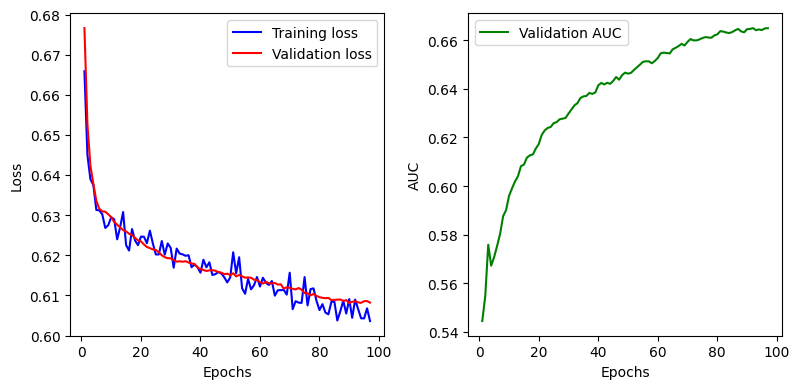

**Train the final model**

In [ ]:
best_params = {'num_channels': '32,64', 'kernel_size': 7, 'dropout_prob': 0.25, 'learning_rate': 0.0001, 'batch_size': 256, 'num_epochs': 100, 'sampling_method': 'normal', 'loss': 'normal', 'weight_decay': 1e-05, 'ffnn_layers': 3, 'ffnn_units': 67, 'ffnn_activation': 'leaky_relu', 'ffnn_dropout': 0.5}
best_params

{'num_channels': '32,64',
 'kernel_size': 7,
 'dropout_prob': 0.25,
 'learning_rate': 0.0001,
 'batch_size': 256,
 'num_epochs': 100,
 'sampling_method': 'normal',
 'loss': 'normal',
 'weight_decay': 1e-05,
 'ffnn_layers': 3,
 'ffnn_units': 67,
 'ffnn_activation': 'leaky_relu',
 'ffnn_dropout': 0.5}

In [ ]:
# Change ffn units to 64
best_params['ffnn_units'] = 64
best_params

{'num_channels': '32,64',
 'kernel_size': 7,
 'dropout_prob': 0.25,
 'learning_rate': 0.0001,
 'batch_size': 256,
 'num_epochs': 100,
 'sampling_method': 'normal',
 'loss': 'normal',
 'weight_decay': 1e-05,
 'ffnn_layers': 3,
 'ffnn_units': 64,
 'ffnn_activation': 'leaky_relu',
 'ffnn_dropout': 0.5}

In [ ]:
final_model = FusedTCN_FFNN(
    low_input_dim=low_freq_train_sequences.shape[2],
    medium_input_dim=medium_freq_train_sequences.shape[2],
    high_input_dim=high_freq_train_sequences.shape[2],
    num_channels=[int(x) for x in best_params['num_channels'].split(',')],
    kernel_size=best_params['kernel_size'],
    dropout=best_params['dropout_prob'],
    seq_lengths={'low': low_freq_train_sequences.shape[1], 'medium': medium_freq_train_sequences.shape[1], 'high': high_freq_train_sequences.shape[1]},
    static_input_size=train_static.shape[1],
    ffnn_layers=best_params['ffnn_layers'],
    ffnn_units=best_params['ffnn_units'],
    ffnn_activation=best_params['ffnn_activation'],
    ffnn_dropout=best_params['ffnn_dropout']
).to(device)

final_model

FusedTCN_FFNN(
  (low_tcn): TCN(
    (network): Sequential(
      (0): TemporalBlock(
        (conv1): Conv1d(3, 32, kernel_size=(7,), stride=(1,), padding=(6,))
        (chomp1): Chomp1d()
        (relu1): ReLU()
        (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout1): Dropout(p=0.25, inplace=False)
        (conv2): Conv1d(32, 32, kernel_size=(7,), stride=(1,), padding=(6,))
        (chomp2): Chomp1d()
        (relu2): ReLU()
        (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout2): Dropout(p=0.25, inplace=False)
        (net): Sequential(
          (0): Conv1d(3, 32, kernel_size=(7,), stride=(1,), padding=(6,))
          (1): Chomp1d()
          (2): ReLU()
          (3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (4): Dropout(p=0.25, inplace=False)
          (5): Conv1d(32, 32, kernel_size=(7,), stride=(1,), padding=(6,))
 

In [ ]:
# Handle sampling methods
if best_params['sampling_method'] == 'undersample':
      train_low_resampled, train_medium_resampled, train_high_resampled, train_static_resampled, train_labels_resampled = undersample_data(
          low_freq_train_sequences, medium_freq_train_sequences, high_freq_train_sequences, train_static, labels_train)
elif best_params['sampling_method'] == 'oversample':
      train_low_resampled, train_medium_resampled, train_high_resampled, train_static_resampled, train_labels_resampled = oversample_data(
          low_freq_train_sequences, medium_freq_train_sequences, high_freq_train_sequences, train_static, labels_train)
else:
      train_low_resampled, train_medium_resampled, train_high_resampled, train_static_resampled, train_labels_resampled = low_freq_train_sequences, medium_freq_train_sequences, high_freq_train_sequences, train_static, labels_train

# Define the loss function
if best_params['loss'] == 'weighted':
  pos_weight = torch.tensor([best_params['pos_weight']]).to(device)
  criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
else:
  criterion = nn.BCELoss()

# Define the optimiser
optimizer = optim.Adam(
    final_model.parameters(),
    lr=best_params['learning_rate'],
    weight_decay=best_params['weight_decay']
)

# Define the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
final_model.to(device)

# Create data loaders
train_loader, _, test_loader = create_multi_input_data_loaders(
  train_low_resampled, train_medium_resampled, train_high_resampled, train_static_resampled, train_labels_resampled,
  _, _, _, _, _,
  low_freq_test_sequences, medium_freq_test_sequences, high_freq_test_sequences, test_static, labels_test,
  batch_size=best_params['batch_size']
)

Epoch 1/100, Loss: 0.9995
Epoch 2/100, Loss: 0.8293
Epoch 3/100, Loss: 0.7852
Epoch 4/100, Loss: 0.7503
Epoch 5/100, Loss: 0.7399
Epoch 6/100, Loss: 0.7241
Epoch 7/100, Loss: 0.7335
Epoch 8/100, Loss: 0.6966
Epoch 9/100, Loss: 0.6987
Epoch 10/100, Loss: 0.6779
Epoch 11/100, Loss: 0.6832
Epoch 12/100, Loss: 0.6869
Epoch 13/100, Loss: 0.6667
Epoch 14/100, Loss: 0.6638
Epoch 15/100, Loss: 0.6562
Epoch 16/100, Loss: 0.6659
Epoch 17/100, Loss: 0.6581
Epoch 18/100, Loss: 0.6579
Epoch 19/100, Loss: 0.6468
Epoch 20/100, Loss: 0.6476
Epoch 21/100, Loss: 0.6481
Epoch 22/100, Loss: 0.6460
Epoch 23/100, Loss: 0.6548
Epoch 24/100, Loss: 0.6453
Epoch 25/100, Loss: 0.6436
Epoch 26/100, Loss: 0.6424
Epoch 27/100, Loss: 0.6357
Epoch 28/100, Loss: 0.6413
Epoch 29/100, Loss: 0.6362
Epoch 30/100, Loss: 0.6353
Epoch 31/100, Loss: 0.6335
Epoch 32/100, Loss: 0.6366
Epoch 33/100, Loss: 0.6297
Epoch 34/100, Loss: 0.6350
Epoch 35/100, Loss: 0.6291
Epoch 36/100, Loss: 0.6258
Epoch 37/100, Loss: 0.6288
Epoch 38/1

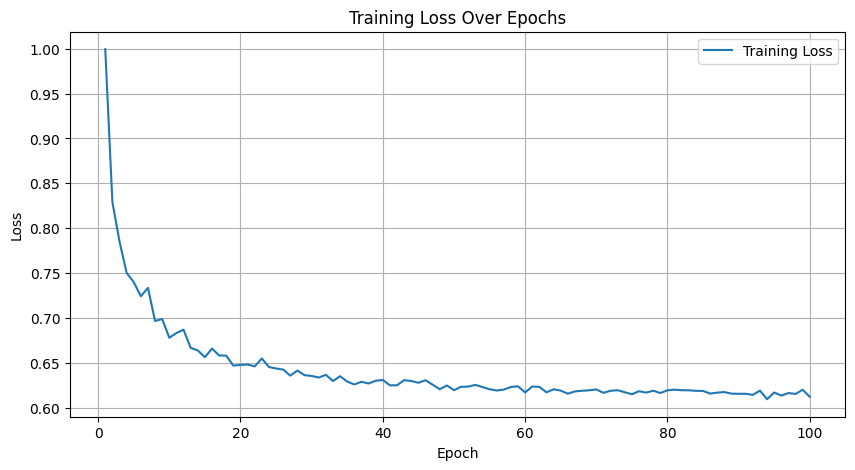

In [ ]:
# Train the model
final_model, train_losses = train_final_model(
    final_model,
    train_loader,
    criterion,
    optimizer,
    num_epochs=best_params['num_epochs'],
    device=device,
)

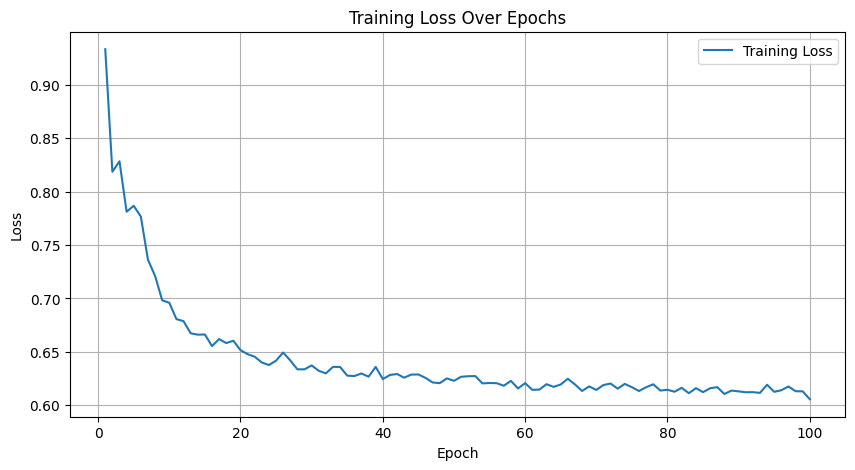

In [ ]:
# Save the trained model
model_path = '/content/drive/MyDrive/MSc_Final_Project/03_model_development/01_feature_set_1/05_tcn_model_fused_decision/static_and_dynamic_data/best_models/experiment_1/final_model.pkl'
with open(model_path, 'wb') as file:
    pickle.dump(final_model, file)

**Evaluate final model**

In [ ]:
def evaluate_model(model, test_loader, device):
    """
    Evaluate the model on the test dataset and calculate various evaluation metrics.

    Parameters:
    model (nn.Module): The trained model to evaluate.
    test_loader (DataLoader): The DataLoader for the test dataset.
    device (torch.device): The device to run the model on.

    Returns:
    tuple: A tuple containing accuracy, precision, recall, F1 score, ROC AUC, and specificity.
    """
    model.to(device)
    model.eval()
    test_outputs = []
    test_labels = []

    with torch.no_grad():
        for data in test_loader:
            low_freq_sequences = data['low_freq_sequence'].to(device)
            medium_freq_sequences = data['medium_freq_sequence'].to(device)
            high_freq_sequences = data['high_freq_sequence'].to(device)
            static_data = data['static'].to(device)  # Static data input
            labels = data['label'].to(device).view(-1, 1)  # Ensure labels have shape [batch_size, 1]

            outputs = model(low_freq_sequences, medium_freq_sequences, high_freq_sequences, static_data)
            test_outputs.extend(outputs.cpu().numpy().flatten())
            test_labels.extend(labels.cpu().numpy().flatten())

    test_outputs = np.array(test_outputs)
    test_labels = np.array(test_labels)

    # Calculate various metrics
    accuracy = accuracy_score(test_labels, test_outputs.round())
    precision = precision_score(test_labels, test_outputs.round())
    recall = recall_score(test_labels, test_outputs.round())
    f1 = f1_score(test_labels, test_outputs.round())
    roc_auc = roc_auc_score(test_labels, test_outputs)
    tn, fp, fn, tp = confusion_matrix(test_labels, test_outputs.round()).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall (Sensitivity): {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'ROC AUC: {roc_auc:.4f}')
    print(f'Specificity: {specificity:.4f}')

    return (accuracy, precision, recall, f1, roc_auc, specificity), test_outputs

In [ ]:
# Evaluate final model
evaluate_model(final_model, test_loader, device)

Accuracy: 0.6812
Precision: 0.6667
Recall (Sensitivity): 0.0583
F1 Score: 0.1071
ROC AUC: 0.6451
Specificity: 0.9858


(0.6811902231668437,
 0.6666666666666666,
 0.05825242718446602,
 0.10714285714285714,
 0.6450626766621606,
 0.9857594936708861)

Performance is analogous to without static data but slightly better ROC AUC curve.



In [ ]:
def calculate_f1_minority(model, test_loader, device):
    """
    Calculate the F1 score for the minority class.

    Parameters:
    model (nn.Module): Trained LSTM model.
    test_loader (DataLoader): DataLoader for the test data.
    device (torch.device): Device to run the model on (CPU or GPU).

    Returns:
    float: F1 score for the minority class.
    """
    model.to(device)
    model.eval()

    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for data in test_loader:
            low_freq_sequences = data['low_freq_sequence'].to(device)
            medium_freq_sequences = data['medium_freq_sequence'].to(device)
            high_freq_sequences = data['high_freq_sequence'].to(device)
            static_data = data['static'].to(device)
            labels = data['label'].to(device)

            outputs = model(low_freq_sequences, medium_freq_sequences, high_freq_sequences, static_data)
            predictions = (outputs >= 0.5).cpu().numpy().astype(int)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions)

    # Calculate F1 score for the minority class (class 1)
    f1_minority = f1_score(all_labels, all_predictions, average='binary', pos_label=1)
    return f1_minority

In [ ]:
calculate_f1_minority(final_model, test_loader, device)

0.10714285714285714

**Confusion matrix**

In [ ]:
def get_model_predictions(model, test_loader, device):
    """
    Get model predictions and true labels from the test data.

    Parameters:
    model (nn.Module): Trained model.
    test_loader (DataLoader): DataLoader for the test data.
    device (torch.device): Device to run the model on (CPU or GPU).

    Returns:
    tuple: A tuple containing true labels, predicted labels, and output scores.
    """
    model.to(device)
    model.eval()

    # Ensure the LSTM weights are compacted
    if hasattr(model, 'lstm'):
        model.lstm.flatten_parameters()

    y_true = []
    y_pred = []
    y_scores = []

    with torch.no_grad():
        for data in test_loader:
            low_freq_test_sequences = data['low_freq_sequence'].to(device)
            medium_freq_test_sequences = data['medium_freq_sequence'].to(device)
            high_freq_test_sequences = data['high_freq_sequence'].to(device)
            static_data = data['static'].to(device)
            labels = data['label'].to(device).view(-1, 1)  # Ensure labels have shape [batch_size, 1]

            outputs = model(low_freq_test_sequences, medium_freq_test_sequences, high_freq_test_sequences, static_data)

            preds = (outputs >= 0.5).float()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_scores.extend(outputs.cpu().numpy())

    return np.array(y_true), np.array(y_pred), np.array(y_scores)

In [ ]:
def plot_confusion_matrix(cm, class_names):
    """
    Plot the confusion matrix using seaborn heatmap.

    Parameters:
    cm (array-like): Confusion matrix.
    class_names (list): List of class names.
    """
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Define class names
class_names = ['extubation_success', 'extubation_failure']  # Replace with your actual class names if different

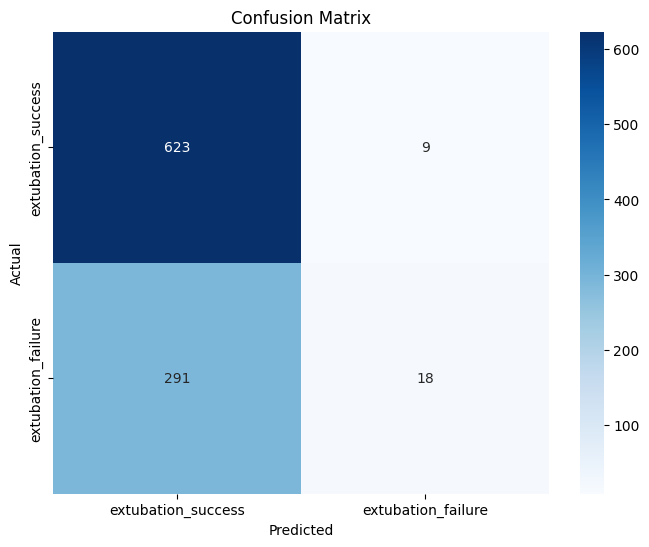

In [ ]:
y_true, y_pred, y_scores = get_model_predictions(final_model, test_loader, device)

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plot_confusion_matrix(cm, class_names)

Very few of the extubation failure class are being predicted. There is a bias towards extubation success which is expected due to data imbalance.

**Plot ROC curve**

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from sklearn.metrics import roc_curve

def plot_roc_curve(model, test_loader, device):
    """
    Generates and plots the ROC curve for the given model and test data.

    Parameters:
    model (torch.nn.Module): The trained model.
    test_loader (DataLoader): DataLoader for the test data.
    device (torch.device): The device to run the model on (CPU or GPU).

    Returns:
    None
    """
    model.to(device)
    model.eval()

    all_probs = []
    all_labels = []

    with torch.no_grad():
        for data in test_loader:
            low_freq_sequences = data['low_freq_sequence'].to(device)
            medium_freq_sequences = data['medium_freq_sequence'].to(device)
            high_freq_sequences = data['high_freq_sequence'].to(device)
            static_data = data['static'].to(device)
            labels = data['label'].to(device).view(-1, 1)

            # Get model output (predicted probabilities)
            output = model(low_freq_sequences, medium_freq_sequences, high_freq_sequences, static_data)

            # Append predicted probabilities and true labels
            all_probs.extend(output.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())

    # Convert lists to numpy arrays
    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)

    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(roc_auc_score(all_labels, all_probs)))
    plt.plot([0, 1], [0, 1], 'k--', label='Random chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

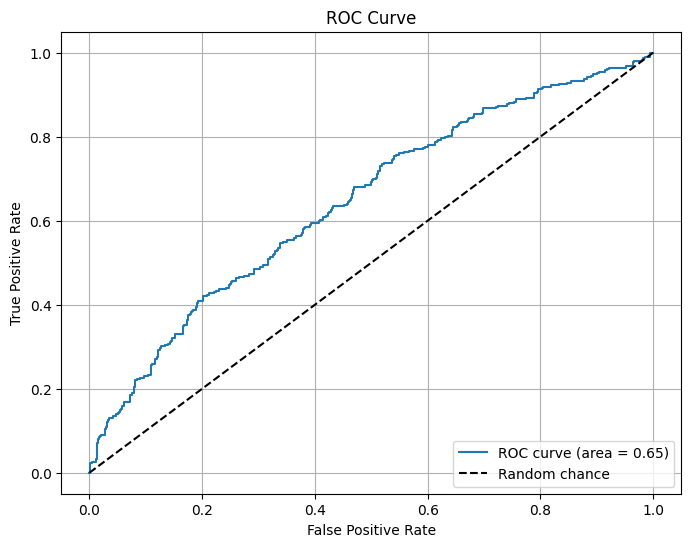

In [ ]:
plot_roc_curve(final_model, test_loader, device)

**Classification Threshold**

In [ ]:
import numpy as np
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def find_best_threshold_and_evaluate(model, test_loader, device):
    """
    Find the best threshold for binary classification based on ROC AUC and calculate evaluation metrics.

    Parameters:
    model (nn.Module): The trained model.
    test_loader (DataLoader): DataLoader for the test data.
    device (torch.device): Device to run the model on (CPU or GPU).

    Returns:
    dict: A dictionary containing the best threshold, ROC AUC, and other evaluation metrics.
    """
    model.eval()  # Set the model to evaluation mode

    all_probs = []
    all_labels = []

    with torch.no_grad():
        for data in test_loader:
            low_freq_sequences = data['low_freq_sequence'].to(device)
            medium_freq_sequences = data['medium_freq_sequence'].to(device)
            high_freq_sequences = data['high_freq_sequence'].to(device)
            static_data = data['static'].to(device)
            labels = data['label'].to(device).view(-1, 1)

            # Get model output (predicted probabilities)
            output = model(low_freq_sequences, medium_freq_sequences, high_freq_sequences, static_data)

            # Append predicted probabilities and true labels
            all_probs.extend(output.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())

    # Convert lists to numpy arrays
    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)

    best_threshold = 0.5
    best_metric_value = 0.0

    thresholds = np.arange(0.0, 1.0, 0.01)  # You can change the step size if needed

    for threshold in thresholds:
        preds = (all_probs >= threshold).astype(int)
        metric_value = f1_score(all_labels, preds)

        if metric_value > best_metric_value:
            best_metric_value = metric_value
            best_threshold = threshold

    # Apply the best threshold to get the final predictions
    final_preds = (all_probs >= best_threshold).astype(int)

    # Calculate the final evaluation metrics
    accuracy = accuracy_score(all_labels, final_preds)
    precision = precision_score(all_labels, final_preds)
    recall = recall_score(all_labels, final_preds)
    f1 = f1_score(all_labels, final_preds)
    roc_auc = roc_auc_score(all_labels, all_probs)  # Use probabilities for ROC AUC
    specificity = recall_score(all_labels, final_preds, pos_label=0)

    metrics = {
        'best_threshold': best_threshold,
        'best_metric_value': best_metric_value,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'specificity': specificity
    }

    print(f"Best Threshold: {best_threshold}")
    print(f"Best Metric Value: {best_metric_value}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"Specificity: {specificity:.4f}")

    return metrics

In [ ]:
find_best_threshold_and_evaluate(final_model, test_loader, device)

Best Threshold: 0.33
Best Metric Value: 0.6057463848265127
Accuracy: 0.6748
Precision: 0.5061
Recall: 0.4045
F1 Score: 0.4496
ROC AUC: 0.6451
Specificity: 0.8070


{'best_threshold': 0.33,
 'best_metric_value': 0.6057463848265127,
 'accuracy': 0.6748140276301806,
 'precision': 0.5060728744939271,
 'recall': 0.4045307443365696,
 'f1_score': 0.4496402877697842,
 'roc_auc': 0.6450626766621606,
 'specificity': 0.8069620253164557}

### **Model Interpretability**

In [ ]:
# Load the feature names
low_feature_names = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/dynamic_data/feature_subsets_run_2/low_freq_feature_names_v1.npy'
medium_feature_names = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/dynamic_data/feature_subsets_run_2/medium_freq_feature_names_v1.npy'
high_fxeature_names = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/dynamic_data/feature_subsets_run_2/high_freq_feature_names_v1.npy'

low_freq_feature_names = np.load(low_feature_names, allow_pickle=True)
medium_freq_feature_names = np.load(medium_feature_names, allow_pickle=True)
high_freq_feature_names = np.load(high_feature_names, allow_pickle=True)

print(low_freq_feature_names)
print(medium_freq_feature_names)
print(high_freq_feature_names)

NameError: name 'high_feature_names' is not defined

In [ ]:
# Load static feature names
train_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/static_data/train_static_final_v2.parquet'
train_df = pd.read_parquet(train_path)
static_feature_names = train_df.columns.tolist()

# Remove subject_id from the feature list
static_feature_names.remove('subject_id')

# Print the shape of the loaded feature names
print(f"Feature names shape: {len(static_feature_names)}")

Feature names shape: 36


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from collections import defaultdict

def feature_ablation_with_names(low_train_sequences, medium_train_sequences, high_train_sequences, train_static, train_labels,
                                low_test_sequences, medium_test_sequences, high_test_sequences, test_static, test_labels,
                                model, best_hyperparams, device, low_feature_names, medium_feature_names, high_feature_names, feature_names_static):
    """
    Perform feature ablation by retraining the model without each feature.

    Parameters:
    train_sequences (np.array): The training sequences.
    train_static (np.array): The training static features.
    train_labels (np.array): The training labels.
    test_sequences (np.array): The test sequences.
    test_static (np.array): The test static features.
    test_labels (np.array): The test labels.
    model (nn.Module): The trained TCN model.
    best_hyperparams (dict): The best hyperparameters.
    device (torch.device): The device to run the model on.
    low_feature_names (list): List of low frequency feature names.
    medium_feature_names (list): List of medium frequency feature names.
    high_feature_names (list): List of high frequency feature names.
    feature_names_static (list): List of static feature names.

    Returns:
    pd.DataFrame: DataFrame containing the feature importances.
    """
    def evaluate_model_ablation(model, data_loader, criterion, device):
        model.eval()
        all_labels = []
        all_outputs = []
        total_loss = 0.0

        with torch.no_grad():
            for data in data_loader:
                low_sequences = data['low_freq_sequence'].to(device)
                medium_sequences = data['medium_freq_sequence'].to(device)
                high_sequences = data['high_freq_sequence'].to(device)
                static = data['static'].to(device)
                labels = data['label'].to(device).view(-1, 1)  # Ensure labels have shape [batch_size, 1]

                outputs = model(low_sequences, medium_sequences, high_sequences, static)
                loss = criterion(outputs, labels)
                total_loss += loss.item() * low_sequences.size(0)

                all_outputs.extend(outputs.cpu().numpy().flatten())
                all_labels.extend(labels.cpu().numpy().flatten())

        avg_loss = total_loss / len(data_loader.dataset)
        accuracy = accuracy_score(all_labels, (np.array(all_outputs) > 0.5).astype(int))
        precision = precision_score(all_labels, (np.array(all_outputs) > 0.5).astype(int))
        recall = recall_score(all_labels, (np.array(all_outputs) > 0.5).astype(int))
        f1 = f1_score(all_labels, (np.array(all_outputs) > 0.5).astype(int))
        roc_auc = roc_auc_score(all_labels, all_outputs)
        specificity = recall_score(all_labels, (np.array(all_outputs) <= 0.5).astype(int))

        return avg_loss, accuracy, precision, recall, f1, roc_auc, specificity

    feature_importances = defaultdict(dict)
    input_dim_static = train_static.shape[1]

    criterion = nn.BCELoss()
    _, base_accuracy, base_precision, base_recall, base_f1, base_roc_auc, base_specificity = evaluate_model_ablation(
        model,
        DataLoader(MultiInputTimeSeriesDataset(low_test_sequences, medium_test_sequences, high_test_sequences, test_static, test_labels), batch_size=best_hyperparams['batch_size'], shuffle=False),
        criterion,
        device
    )

    # Ablation for low frequency features
    for feature_idx, feature_name in enumerate(low_feature_names):
        print(f"Ablating low frequency feature {feature_name} ({feature_idx + 1}/{len(low_feature_names)})")

        # Remove the feature from the sequences
        low_train_sequences_ablation = np.delete(low_train_sequences, feature_idx, axis=2)
        low_test_sequences_ablation = np.delete(low_test_sequences, feature_idx, axis=2)

        # Create data loaders
        train_loader, val_loader, test_loader = create_multi_input_data_loaders(
            low_train_sequences_ablation, medium_train_sequences, high_train_sequences, train_static, train_labels,
            low_train_sequences_ablation, medium_train_sequences, high_train_sequences, train_static, train_labels,
            low_test_sequences_ablation, medium_test_sequences, high_test_sequences, test_static, test_labels,
            best_hyperparams['batch_size']
        )

        # Initialize a new model for this ablation
        ablation_model = FusedTCN_FFNN(
            low_input_dim=low_train_sequences_ablation.shape[2],
            medium_input_dim=medium_train_sequences.shape[2],
            high_input_dim=high_train_sequences.shape[2],
            num_channels=[int(x) for x in best_hyperparams['num_channels'].split(',')],
            kernel_size=best_hyperparams['kernel_size'],
            dropout=best_hyperparams['dropout_prob'],
            seq_lengths={'low': low_train_sequences_ablation.shape[1], 'medium': medium_train_sequences.shape[1], 'high': high_train_sequences.shape[1]},
            static_input_size=train_static.shape[1],
            ffnn_layers=best_hyperparams['ffnn_layers'],
            ffnn_units=best_hyperparams['ffnn_units'],
            ffnn_activation=best_hyperparams['ffnn_activation'],
            ffnn_dropout=best_hyperparams['ffnn_dropout']
        ).to(device)

        optimizer = torch.optim.Adam(ablation_model.parameters(), lr=best_hyperparams['learning_rate'], weight_decay=best_hyperparams['weight_decay'])

        # Train the model
        ablation_model, _, _, _ = train_fused_model_with_early_stopping_logging(
            ablation_model, train_loader, val_loader, criterion, optimizer,
            best_hyperparams['num_epochs'], device, patience=5, output_path='checkpoint.pth'
        )

        # Evaluate the model
        _, accuracy, precision, recall, f1, roc_auc, specificity = evaluate_model_ablation(ablation_model, test_loader, criterion, device)

        feature_importances['low'][feature_name] = {
            'accuracy': base_accuracy - accuracy,
            'precision': base_precision - precision,
            'recall': base_recall - recall,
            'f1': base_f1 - f1,
            'roc_auc': base_roc_auc - roc_auc,
            'specificity': base_specificity - specificity
        }

    # Ablation for medium frequency features
    for feature_idx, feature_name in enumerate(medium_feature_names):
        print(f"Ablating medium frequency feature {feature_name} ({feature_idx + 1}/{len(medium_feature_names)})")

        # Remove the feature from the sequences
        medium_train_sequences_ablation = np.delete(medium_train_sequences, feature_idx, axis=2)
        medium_test_sequences_ablation = np.delete(medium_test_sequences, feature_idx, axis=2)

        # Create data loaders
        train_loader, val_loader, test_loader = create_multi_input_data_loaders(
            low_train_sequences, medium_train_sequences_ablation, high_train_sequences, train_static, train_labels,
            low_train_sequences, medium_train_sequences_ablation, high_train_sequences, train_static, train_labels,
            low_test_sequences, medium_test_sequences_ablation, high_test_sequences, test_static, test_labels,
            best_hyperparams['batch_size']
        )

        # Initialize a new model for this ablation
        ablation_model = FusedTCN_FFNN(
            low_input_dim=low_train_sequences.shape[2],
            medium_input_dim=medium_train_sequences_ablation.shape[2],
            high_input_dim=high_train_sequences.shape[2],
            num_channels=[int(x) for x in best_hyperparams['num_channels'].split(',')],
            kernel_size=best_hyperparams['kernel_size'],
            dropout=best_hyperparams['dropout_prob'],
            seq_lengths={'low': low_train_sequences.shape[1], 'medium': medium_train_sequences_ablation.shape[1], 'high': high_train_sequences.shape[1]},
            static_input_size=train_static.shape[1],
            ffnn_layers=best_hyperparams['ffnn_layers'],
            ffnn_units=best_hyperparams['ffnn_units'],
            ffnn_activation=best_hyperparams['ffnn_activation'],
            ffnn_dropout=best_hyperparams['ffnn_dropout']
        ).to(device)

        optimizer = torch.optim.Adam(ablation_model.parameters(), lr=best_hyperparams['learning_rate'], weight_decay=best_hyperparams['weight_decay'])

        # Train the model
        ablation_model, _, _, _ = train_fused_model_with_early_stopping_logging(
            ablation_model, train_loader, val_loader, criterion, optimizer,
            best_hyperparams['num_epochs'], device, patience=5, output_path='checkpoint.pth'
        )

        # Evaluate the model
        _, accuracy, precision, recall, f1, roc_auc, specificity = evaluate_model_ablation(ablation_model, test_loader, criterion, device)

        feature_importances['medium'][feature_name] = {
            'accuracy': base_accuracy - accuracy,
            'precision': base_precision - precision,
            'recall': base_recall - recall,
            'f1': base_f1 - f1,
            'roc_auc': base_roc_auc - roc_auc,
            'specificity': base_specificity - specificity
        }

    # Ablation for high frequency features
    for feature_idx, feature_name in enumerate(high_feature_names):
        print(f"Ablating high frequency feature {feature_name} ({feature_idx + 1}/{len(high_feature_names)})")

        # Remove the feature from the sequences
        high_train_sequences_ablation = np.delete(high_train_sequences, feature_idx, axis=2)
        high_test_sequences_ablation = np.delete(high_test_sequences, feature_idx, axis=2)

        # Create data loaders
        train_loader, val_loader, test_loader = create_multi_input_data_loaders(
            low_train_sequences, medium_train_sequences, high_train_sequences_ablation, train_static, train_labels,
            low_train_sequences, medium_train_sequences, high_train_sequences_ablation, train_static, train_labels,
            low_test_sequences, medium_test_sequences, high_test_sequences_ablation, test_static, test_labels,
            best_hyperparams['batch_size']
        )

        # Initialize a new model for this ablation
        ablation_model = FusedTCN_FFNN(
            low_input_dim=low_train_sequences.shape[2],
            medium_input_dim=medium_train_sequences.shape[2],
            high_input_dim=high_train_sequences_ablation.shape[2],
            num_channels=[int(x) for x in best_hyperparams['num_channels'].split(',')],
            kernel_size=best_hyperparams['kernel_size'],
            dropout=best_hyperparams['dropout_prob'],
            seq_lengths={'low': low_train_sequences.shape[1], 'medium': medium_train_sequences.shape[1], 'high': high_train_sequences_ablation.shape[1]},
            static_input_size=train_static.shape[1],
            ffnn_layers=best_hyperparams['ffnn_layers'],
            ffnn_units=best_hyperparams['ffnn_units'],
            ffnn_activation=best_hyperparams['ffnn_activation'],
            ffnn_dropout=best_hyperparams['ffnn_dropout']
        ).to(device)

        optimizer = torch.optim.Adam(ablation_model.parameters(), lr=best_hyperparams['learning_rate'], weight_decay=best_hyperparams['weight_decay'])

        # Train the model
        ablation_model, _, _, _ = train_fused_model_with_early_stopping_logging(
            ablation_model, train_loader, val_loader, criterion, optimizer,
            best_hyperparams['num_epochs'], device, patience=5, output_path='checkpoint.pth'
        )

        # Evaluate the model
        _, accuracy, precision, recall, f1, roc_auc, specificity = evaluate_model_ablation(ablation_model, test_loader, criterion, device)

        feature_importances['high'][feature_name] = {
            'accuracy': base_accuracy - accuracy,
            'precision': base_precision - precision,
            'recall': base_recall - recall,
            'f1': base_f1 - f1,
            'roc_auc': base_roc_auc - roc_auc,
            'specificity': base_specificity - specificity
        }

    # Ablation for static features
    for feature_idx, feature_name in enumerate(feature_names_static):
        print(f"Ablating static feature {feature_name} ({feature_idx + 1}/{len(feature_names_static)})")

        # Remove the feature from the static data
        train_static_ablation = np.delete(train_static, feature_idx, axis=1)
        test_static_ablation = np.delete(test_static, feature_idx, axis=1)

        # Create data loaders
        train_loader, val_loader, test_loader = create_multi_input_data_loaders(
            low_train_sequences, medium_train_sequences, high_train_sequences, train_static_ablation, train_labels,
            low_train_sequences, medium_train_sequences, high_train_sequences, train_static_ablation, train_labels,
            low_test_sequences, medium_test_sequences, high_test_sequences, test_static_ablation, test_labels,
            best_hyperparams['batch_size']
        )

        # Initialize a new model for this ablation
        ablation_model = FusedTCN_FFNN(
            low_input_dim=low_train_sequences.shape[2],
            medium_input_dim=medium_train_sequences.shape[2],
            high_input_dim=high_train_sequences.shape[2],
            num_channels=[int(x) for x in best_hyperparams['num_channels'].split(',')],
            kernel_size=best_hyperparams['kernel_size'],
            dropout=best_hyperparams['dropout_prob'],
            seq_lengths={'low': low_train_sequences.shape[1], 'medium': medium_train_sequences.shape[1], 'high': high_train_sequences.shape[1]},
            static_input_size=train_static_ablation.shape[1],
            ffnn_layers=best_hyperparams['ffnn_layers'],
            ffnn_units=best_hyperparams['ffnn_units'],
            ffnn_activation=best_hyperparams['ffnn_activation'],
            ffnn_dropout=best_hyperparams['ffnn_dropout']
        ).to(device)

        optimizer = torch.optim.Adam(ablation_model.parameters(), lr=best_hyperparams['learning_rate'], weight_decay=best_hyperparams['weight_decay'])

        # Train the model
        ablation_model, _, _, _ = train_fused_model_with_early_stopping_logging(
            ablation_model, train_loader, val_loader, criterion, optimizer,
            best_hyperparams['num_epochs'], device, patience=5, output_path='checkpoint.pth'
        )

        # Evaluate the model
        _, accuracy, precision, recall, f1, roc_auc, specificity = evaluate_model_ablation(ablation_model, test_loader, criterion, device)

        feature_importances['static'][feature_name] = {
            'accuracy': base_accuracy - accuracy,
            'precision': base_precision - precision,
            'recall': base_recall - recall,
            'f1': base_f1 - f1,
            'roc_auc': base_roc_auc - roc_auc,
            'specificity': base_specificity - specificity
        }

    # Combine feature importances for plotting
    combined_feature_importances = {**feature_importances['low'], **feature_importances['medium'], **feature_importances['high'], **feature_importances['static']}

    # Convert feature importances to DataFrames for better readability
    low_importances_df = pd.DataFrame.from_dict(feature_importances['low'], orient='index').sort_values(by='roc_auc', ascending=False)
    medium_importances_df = pd.DataFrame.from_dict(feature_importances['medium'], orient='index').sort_values(by='roc_auc', ascending=False)
    high_importances_df = pd.DataFrame.from_dict(feature_importances['high'], orient='index').sort_values(by='roc_auc', ascending=False)
    static_importances_df = pd.DataFrame.from_dict(feature_importances['static'], orient='index').sort_values(by='roc_auc', ascending=False)
    combined_importances_df = pd.DataFrame.from_dict(combined_feature_importances, orient='index').sort_values(by='roc_auc', ascending=False)

    # Plot low frequency feature importance
    plt.figure(figsize=(12, 8))
    plt.barh(low_importances_df.index, low_importances_df['roc_auc'], align='center', alpha=0.7)
    plt.xlabel('Change in ROC_AUC')
    plt.title('Low Frequency Feature Importance based on change in ROC_AUC')
    plt.gca().invert_yaxis()
    plt.show()

    # Plot medium frequency feature importance
    plt.figure(figsize=(12, 8))
    plt.barh(medium_importances_df.index, medium_importances_df['roc_auc'], align='center', alpha=0.7)
    plt.xlabel('Change in ROC_AUC')
    plt.title('Medium Frequency Feature Importance based on change in ROC_AUC')
    plt.gca().invert_yaxis()
    plt.show()

    # Plot high frequency feature importance
    plt.figure(figsize=(12, 8))
    plt.barh(high_importances_df.index, high_importances_df['roc_auc'], align='center', alpha=0.7)
    plt.xlabel('Change in ROC_AUC')
    plt.title('High Frequency Feature Importance based on change in ROC_AUC')
    plt.gca().invert_yaxis()
    plt.show()

    # Plot static feature importance
    plt.figure(figsize=(12, 8))
    plt.barh(static_importances_df.index, static_importances_df['roc_auc'], align='center', alpha=0.7)
    plt.xlabel('Change in ROC_AUC')
    plt.title('Static Feature Importance based on change in ROC_AUC')
    plt.gca().invert_yaxis()
    plt.show()

    # Plot combined feature importance
    plt.figure(figsize=(12, 8))
    plt.barh(combined_importances_df.index, combined_importances_df['roc_auc'], align='center', alpha=0.7)
    plt.xlabel('Change in ROC_AUC')
    plt.title('Combined Feature Importance based on change in ROC_AUC')
    plt.gca().invert_yaxis()
    plt.show()

    return combined_importances_df

Ablating low frequency feature PH (Arterial) (1/3)
Epoch 0/99, Loss: 0.9417, Val Loss: 0.6520, Val AUC: 0.4876
Epoch 1/99, Loss: 0.8505, Val Loss: 0.6478, Val AUC: 0.4917
Epoch 2/99, Loss: 0.8117, Val Loss: 0.6615, Val AUC: 0.5122
Epoch 3/99, Loss: 0.7682, Val Loss: 0.6649, Val AUC: 0.5268
Epoch 4/99, Loss: 0.7494, Val Loss: 0.6632, Val AUC: 0.5443
Epoch 5/99, Loss: 0.7499, Val Loss: 0.6498, Val AUC: 0.5538
Epoch 6/99, Loss: 0.7232, Val Loss: 0.6461, Val AUC: 0.5611
Epoch 7/99, Loss: 0.7035, Val Loss: 0.6387, Val AUC: 0.5671
Epoch 8/99, Loss: 0.6891, Val Loss: 0.6351, Val AUC: 0.5695
Epoch 9/99, Loss: 0.6936, Val Loss: 0.6315, Val AUC: 0.5737
Epoch 10/99, Loss: 0.6812, Val Loss: 0.6248, Val AUC: 0.5792
Epoch 11/99, Loss: 0.6831, Val Loss: 0.6307, Val AUC: 0.5789
Epoch 12/99, Loss: 0.6725, Val Loss: 0.6244, Val AUC: 0.5812
Epoch 13/99, Loss: 0.6654, Val Loss: 0.6223, Val AUC: 0.5862
Epoch 14/99, Loss: 0.6655, Val Loss: 0.6195, Val AUC: 0.5911
Epoch 15/99, Loss: 0.6619, Val Loss: 0.6190,

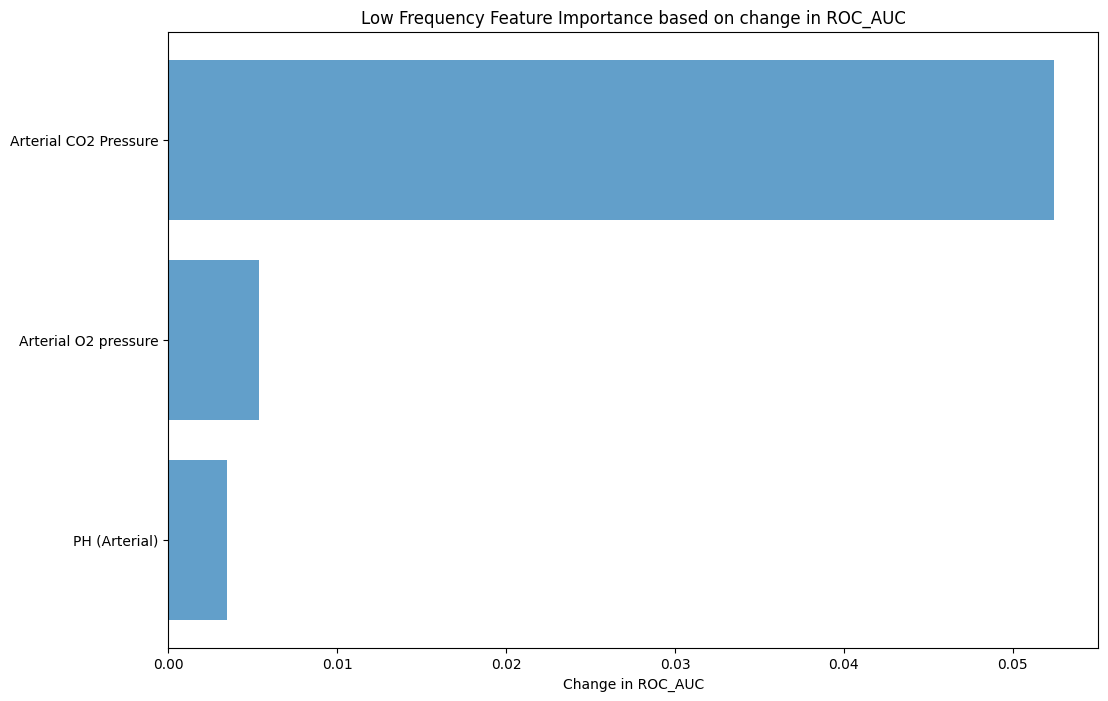

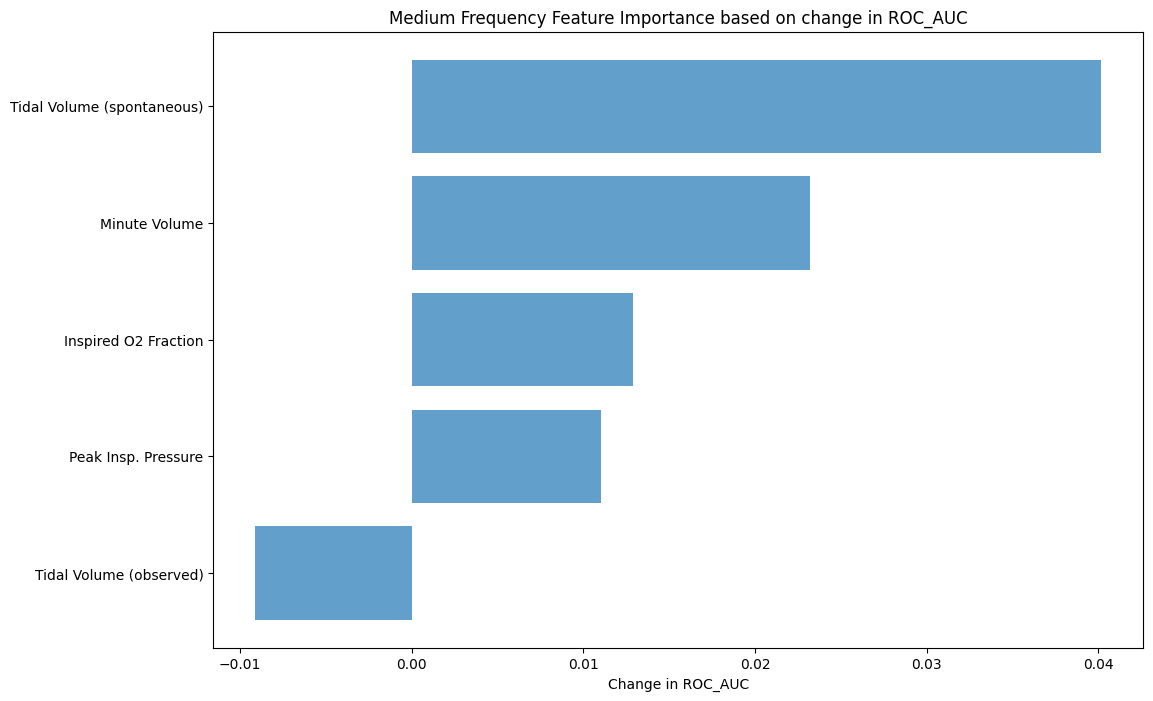

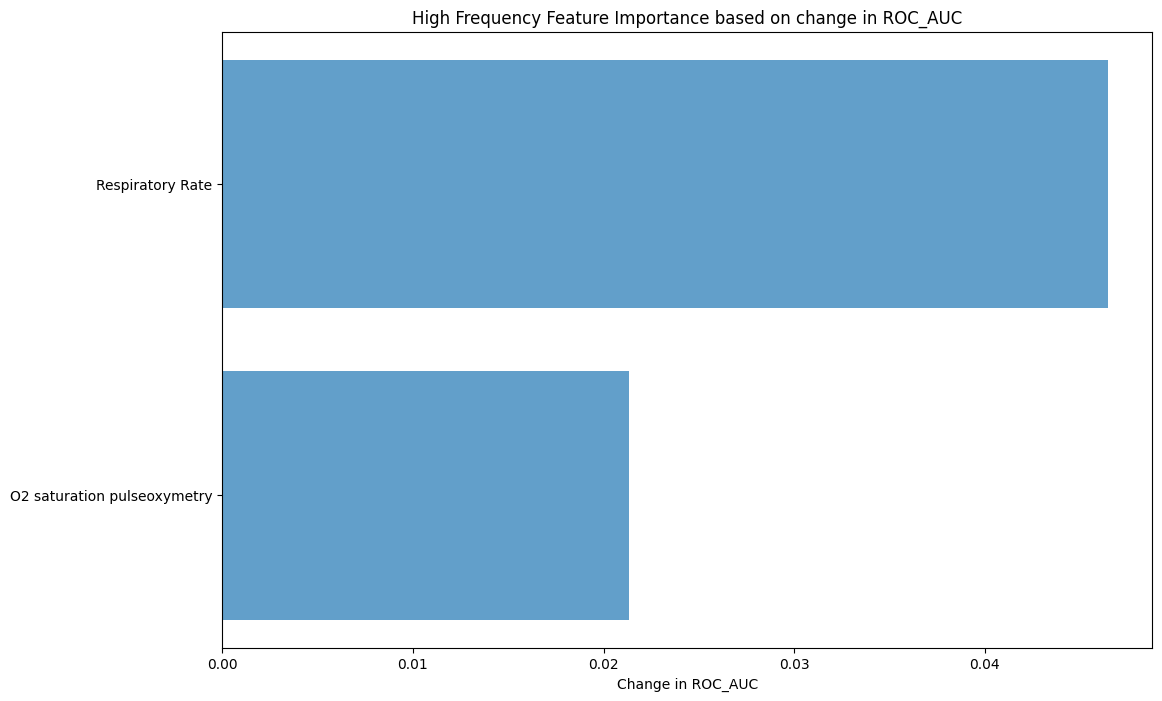

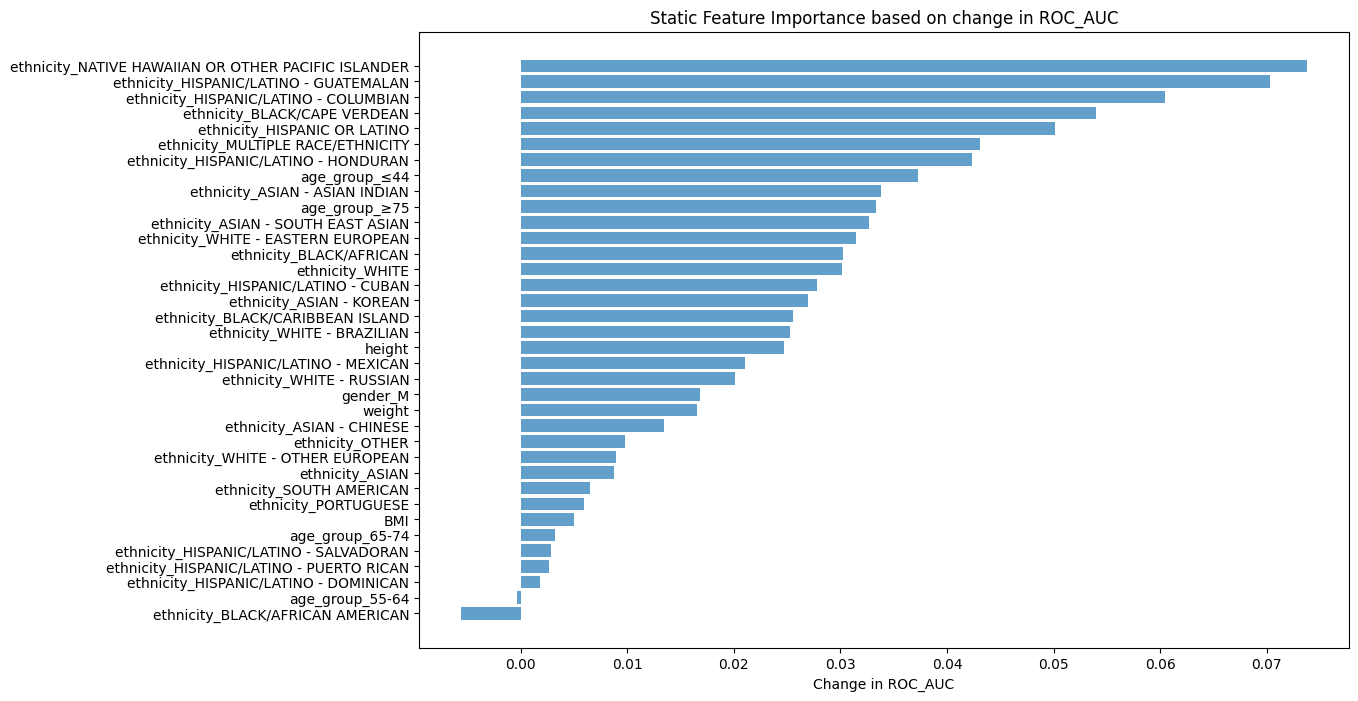

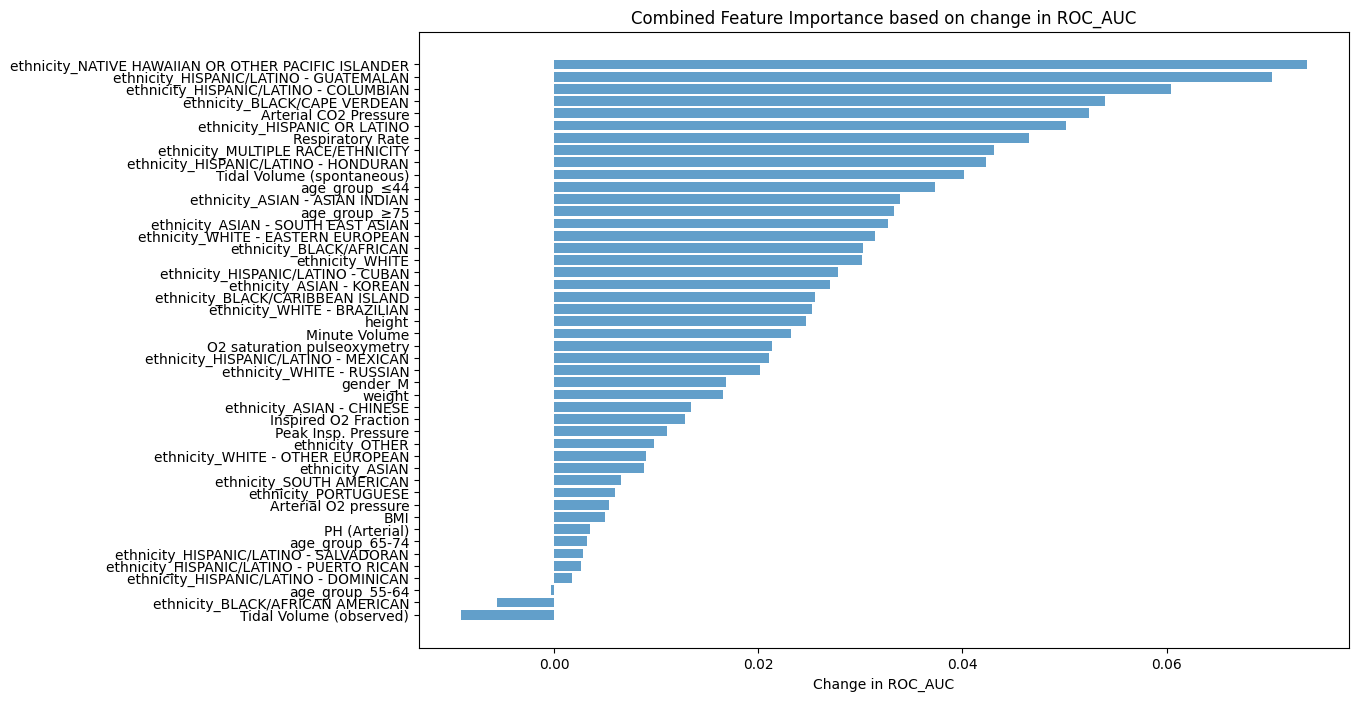

In [ ]:
feature_importances = feature_ablation_with_names(low_freq_train_sequences, medium_freq_train_sequences, high_freq_train_sequences, train_static,
                                                  labels_train, low_freq_test_sequences, medium_freq_test_sequences, high_freq_test_sequences, test_static, labels_test,
                                                  final_model, best_params, device, low_freq_feature_names, medium_freq_feature_names, high_freq_feature_names, static_feature_names)

In [ ]:
feature_importances

,accuracy,precision,recall,f1,roc_auc,specificity
ethnicity_NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER,0.010627,0.181818,0.006472,0.013576,0.073732,-0.006472
ethnicity_HISPANIC/LATINO - GUATEMALAN,0.009564,0.166667,-0.067961,-0.094408,0.070291,0.067961
ethnicity_HISPANIC/LATINO - COLUMBIAN,0.021254,0.236287,-0.051780,-0.068115,0.060398,0.051780
ethnicity_BLACK/CAPE VERDEAN,0.006376,0.078431,0.025890,0.045793,0.053956,-0.025890
Arterial CO2 Pressure,0.004251,0.105691,-0.016181,-0.024286,0.052446,0.016181
ethnicity_HISPANIC OR LATINO,0.005313,0.055556,0.022654,0.039865,0.050162,-0.022654
Respiratory Rate,0.008502,0.144928,0.019417,0.034854,0.046475,-0.019417
ethnicity_MULTIPLE RACE/ETHNICITY,0.010627,0.180180,0.000000,0.003097,0.043070,0.000000
ethnicity_HISPANIC/LATINO - HONDURAN,0.005313,0.023810,0.029126,0.051415,0.042337,-0.029126
Tidal Volume (spontaneous),0.006376,0.095238,0.019417,0.034416,0.040146,-0.019417


In [ ]:
# Combine all dynamic feature names
all_dynamic_feature_names = np.concatenate((low_freq_feature_names, medium_freq_feature_names, high_freq_feature_names))
all_dynamic_feature_names = all_dynamic_feature_names.tolist()

In [ ]:
feature_importances['feature'] = feature_importances.index

In [ ]:
def plot_feature_importances(dynamic_feature_names, static_feature_names, ablation_df):
    """
    Plots the feature importances for dynamic and static features based on ROC AUC change.

    Parameters:
    dynamic_feature_names (list): List of dynamic feature names.
    static_feature_names (list): List of static feature names.
    ablation_df (pd.DataFrame): DataFrame containing the feature importances with a 'feature' column and a 'roc_auc' column.
    """
    # Filter dynamic and static features
    dynamic_features_df = ablation_df[ablation_df['feature'].isin(dynamic_feature_names)]
    static_features_df = ablation_df[ablation_df['feature'].isin(static_feature_names)]

    # Plot dynamic features
    plt.figure(figsize=(12, 8))
    plt.barh(dynamic_features_df['feature'], dynamic_features_df['roc_auc'], align='center', alpha=0.7)
    plt.xlabel('Change in ROC_AUC')
    plt.title('Dynamic Feature Importance based on change in ROC_AUC')
    plt.gca().invert_yaxis()
    plt.show()

    # Plot static features
    plt.figure(figsize=(12, 8))
    plt.barh(static_features_df['feature'], static_features_df['roc_auc'], align='center', alpha=0.7)
    plt.xlabel('Change in ROC_AUC')
    plt.title('Static Feature Importance based on change in ROC_AUC')
    plt.gca().invert_yaxis()
    plt.show()

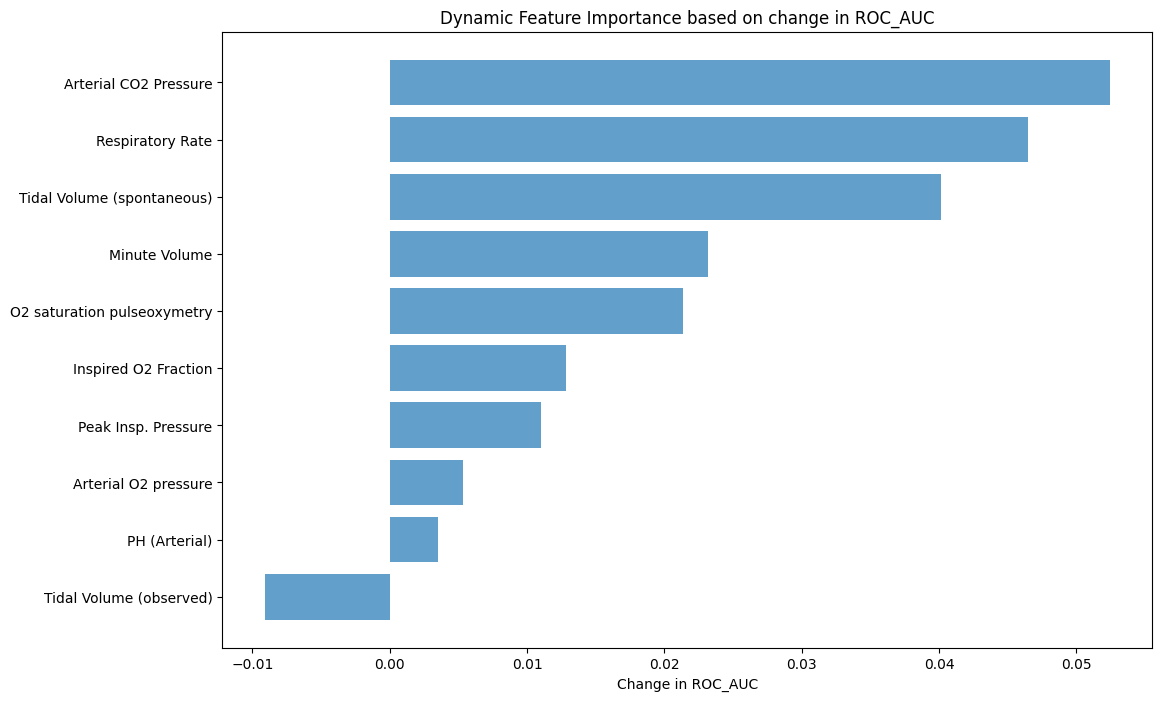

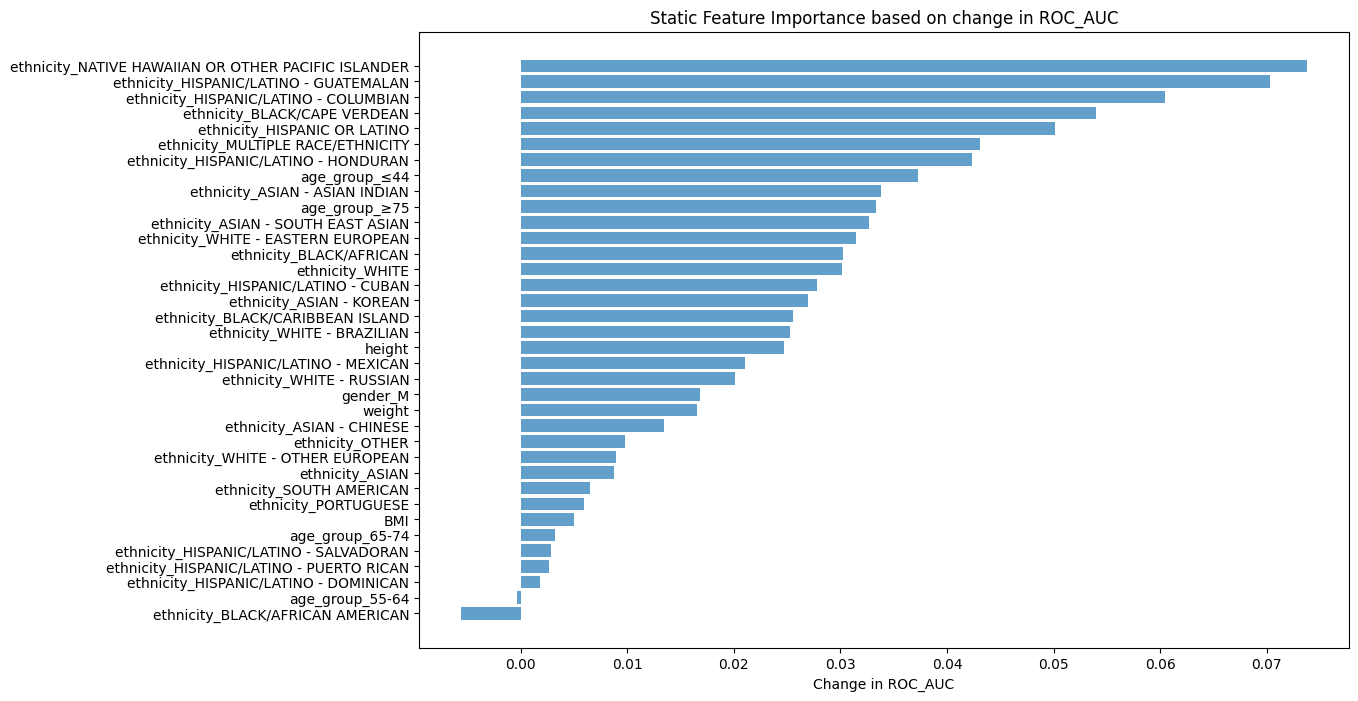

In [ ]:
plot_feature_importances(all_dynamic_feature_names, static_feature_names, feature_importances)

It should be noted that these changes are very very minute and so features have similar importance / the model cannot easily distinguish the importance of them.

**SHAP**

**LIME**

# **Experiment 2 (USE THIS)**

We will now run the experiment with the static data with reduced dimensionality.

In [ ]:
# Load the static data
train_static_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/static_data/old/train_static_v4.npy'
test_static_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/static_data/old/test_static_v4.npy'

train_static = np.load(train_static_path, allow_pickle=True).astype(np.float32)
test_static = np.load(test_static_path, allow_pickle=True).astype(np.float32)

# Print the shapes of the loaded data
print(f"Train static shape: {train_static.shape}")
print(f"Test static shape: {test_static.shape}")

Train static shape: (3760, 14)
Test static shape: (941, 14)


In [ ]:
# Load the subject id order
train_subject_id_order_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/dynamic_data/feature_subsets_run_2/low_df_train_subject_ids_v1.npy'
test_subject_id_order_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/dynamic_data/feature_subsets_run_2/low_df_test_subject_ids_v1.npy'

train_subject_id_order = np.load(train_subject_id_order_path, allow_pickle=True).astype(np.float32)
test_subject_id_order = np.load(test_subject_id_order_path, allow_pickle=True).astype(np.float32)

In [ ]:
# Create a dictionary mapping from subject_id to static features
static_data_dict = {row[0]: row[1:] for row in train_static}

# Reorder static data to match the order of train_subject_id_order
train_static = np.array([static_data_dict[subject_id] for subject_id in train_subject_id_order])

test_static_data_dict = {row[0]: row[1:] for row in test_static}

# Reorder static data to match the order of test_subject_id_order
test_static = np.array([test_static_data_dict[subject_id] for subject_id in test_subject_id_order])

# Print the shapes of the reordered static data
print("Train static shape:", train_static.shape)
print("Test static shape:", test_static.shape)

Train static shape: (3760, 13)
Test static shape: (941, 13)


In [ ]:
# Define new hyperparameter grid
param_grid_exp_2 = {
    'num_channels': [
        '16,32', '32,64', '64,128', '128,256',
        '16,32,64', '32,64,128', '64,128,256'
    ],
    'kernel_size': list(range(2, 11)),  # Kernel sizes from 2 to 10
    'dropout_prob': [0.0, 0.25, 0.5, 0.75], # To mimic LSTM
    'learning_rate': [1e-5, 1e-4, 1e-3, 1e-2],  # Learning rates to explore
    'batch_size': [16, 32, 64, 128, 256],
    'num_epochs': list(range(10, 101, 10)),  # Epochs from 10 to 100
    'sampling_method': ['normal', 'undersample', 'oversample'],
    'loss': ['normal', 'weighted'],
    'weight_decay': [1e-5, 1e-4, 1e-3, 1e-2],
    'ffnn_layers': [1, 2, 3],
    'ffnn_units': [32, 64, 128, 256],
    'ffnn_activation': ['relu', 'tanh', 'sigmoid', 'leaky_relu'],
    'ffnn_dropout': [0.0, 0.25, 0.5, 0.75] # To mimic LSTM range
}

In [ ]:
# Run Bayesian Optimisation
study_exp_2 = optuna.create_study(direction='minimize')
study_exp_2.optimize(objective_wrapper(low_freq_train_sequences, medium_freq_train_sequences,
                                       high_freq_train_sequences, train_static, labels_train, param_grid_exp_2), n_trials=100)

best_params = study_exp_2.best_params
print("Best hyperparameters:", best_params)
best_value = study_exp_2.best_value
print("Best score:", best_value)

# Save best params
params_path = '/content/drive/MyDrive/MSc_Final_Project/03_model_development/01_feature_set_1/05_tcn_model_fused_decision/static_and_dynamic_data/best_models/experiment_2/best_params.json'
with open(params_path, 'w') as f:
    json.dump(best_params, f)

Output hidden; open in https://colab.research.google.com to view.

Best hyperparameters: {'num_channels': '32,64,128', 'kernel_size': 2, 'dropout_prob': 0.25, 'learning_rate': 0.001, 'batch_size': 256, 'num_epochs': 50, 'sampling_method': 'undersample', 'loss': 'normal', 'weight_decay': 0.0001, 'ffnn_layers': 1, 'ffnn_units': 213, 'ffnn_activation': 'tanh', 'ffnn_dropout': 0.75}

Best score: -0.6634383931087227

In [ ]:
best_params = {'num_channels': '32,64,128', 'kernel_size': 2, 'dropout_prob': 0.25, 'learning_rate': 0.001, 'batch_size': 256, 'num_epochs': 50, 'sampling_method': 'undersample', 'loss': 'normal', 'weight_decay': 0.0001, 'ffnn_layers': 1, 'ffnn_units': 213, 'ffnn_activation': 'tanh', 'ffnn_dropout': 0.75}


In [ ]:
# Convert ffnn units to 256
best_params['ffnn_units'] = 256

In [ ]:
best_params

{'num_channels': '32,64,128',
 'kernel_size': 2,
 'dropout_prob': 0.25,
 'learning_rate': 0.001,
 'batch_size': 256,
 'num_epochs': 50,
 'sampling_method': 'undersample',
 'loss': 'normal',
 'weight_decay': 0.0001,
 'ffnn_layers': 1,
 'ffnn_units': 256,
 'ffnn_activation': 'tanh',
 'ffnn_dropout': 0.75}

**Train the final model**

In [ ]:
final_model = FusedTCN_FFNN(
    low_input_dim=low_freq_train_sequences.shape[2],
    medium_input_dim=medium_freq_train_sequences.shape[2],
    high_input_dim=high_freq_train_sequences.shape[2],
    num_channels=[int(x) for x in best_params['num_channels'].split(',')],
    kernel_size=best_params['kernel_size'],
    dropout=best_params['dropout_prob'],
    seq_lengths={'low': low_freq_train_sequences.shape[1], 'medium': medium_freq_train_sequences.shape[1], 'high': high_freq_train_sequences.shape[1]},
    static_input_size=train_static.shape[1],
    ffnn_layers=best_params['ffnn_layers'],
    ffnn_units=best_params['ffnn_units'],
    ffnn_activation=best_params['ffnn_activation'],
    ffnn_dropout=best_params['ffnn_dropout']
).to(device)

final_model

FusedTCN_FFNN(
  (low_tcn): TCN(
    (network): Sequential(
      (0): TemporalBlock(
        (conv1): Conv1d(3, 32, kernel_size=(2,), stride=(1,), padding=(1,))
        (chomp1): Chomp1d()
        (relu1): ReLU()
        (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout1): Dropout(p=0.25, inplace=False)
        (conv2): Conv1d(32, 32, kernel_size=(2,), stride=(1,), padding=(1,))
        (chomp2): Chomp1d()
        (relu2): ReLU()
        (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout2): Dropout(p=0.25, inplace=False)
        (net): Sequential(
          (0): Conv1d(3, 32, kernel_size=(2,), stride=(1,), padding=(1,))
          (1): Chomp1d()
          (2): ReLU()
          (3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (4): Dropout(p=0.25, inplace=False)
          (5): Conv1d(32, 32, kernel_size=(2,), stride=(1,), padding=(1,))
 

In [ ]:
# Handle sampling methods
if best_params['sampling_method'] == 'undersample':
      train_low_resampled, train_medium_resampled, train_high_resampled, train_static_resampled, train_labels_resampled = undersample_data(
          low_freq_train_sequences, medium_freq_train_sequences, high_freq_train_sequences, train_static, labels_train)
elif best_params['sampling_method'] == 'oversample':
      train_low_resampled, train_medium_resampled, train_high_resampled, train_static_resampled, train_labels_resampled = oversample_data(
          low_freq_train_sequences, medium_freq_train_sequences, high_freq_train_sequences, train_static, labels_train)
else:
      train_low_resampled, train_medium_resampled, train_high_resampled, train_static_resampled, train_labels_resampled = low_freq_train_sequences, medium_freq_train_sequences, high_freq_train_sequences, train_static, labels_train

# Define the loss function
if best_params['loss'] == 'weighted':
  pos_weight = torch.tensor([best_params['pos_weight']]).to(device)
  criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
else:
  criterion = nn.BCELoss()

# Define the optimiser
optimizer = optim.Adam(
    final_model.parameters(),
    lr=best_params['learning_rate'],
    weight_decay=best_params['weight_decay']
)

# Define the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
final_model.to(device)

# Create data loaders
train_loader, _, test_loader = create_multi_input_data_loaders(
  train_low_resampled, train_medium_resampled, train_high_resampled, train_static_resampled, train_labels_resampled,
  _, _, _, _, _,
  low_freq_test_sequences, medium_freq_test_sequences, high_freq_test_sequences, test_static, labels_test,
  batch_size=best_params['batch_size']
)

In [ ]:
reset_model(final_model)

Epoch 1/50, Loss: 0.6887
Epoch 2/50, Loss: 0.6684
Epoch 3/50, Loss: 0.6701
Epoch 4/50, Loss: 0.6681
Epoch 5/50, Loss: 0.6602
Epoch 6/50, Loss: 0.6703
Epoch 7/50, Loss: 0.6661
Epoch 8/50, Loss: 0.6627
Epoch 9/50, Loss: 0.6612
Epoch 10/50, Loss: 0.6621
Epoch 11/50, Loss: 0.6590
Epoch 12/50, Loss: 0.6543
Epoch 13/50, Loss: 0.6534
Epoch 14/50, Loss: 0.6553
Epoch 15/50, Loss: 0.6557
Epoch 16/50, Loss: 0.6589
Epoch 17/50, Loss: 0.6526
Epoch 18/50, Loss: 0.6546
Epoch 19/50, Loss: 0.6567
Epoch 20/50, Loss: 0.6508
Epoch 21/50, Loss: 0.6526
Epoch 22/50, Loss: 0.6548
Epoch 23/50, Loss: 0.6576
Epoch 24/50, Loss: 0.6519
Epoch 25/50, Loss: 0.6532
Epoch 26/50, Loss: 0.6543
Epoch 27/50, Loss: 0.6601
Epoch 28/50, Loss: 0.6529
Epoch 29/50, Loss: 0.6500
Epoch 30/50, Loss: 0.6498
Epoch 31/50, Loss: 0.6516
Epoch 32/50, Loss: 0.6523
Epoch 33/50, Loss: 0.6483
Epoch 34/50, Loss: 0.6527
Epoch 35/50, Loss: 0.6465
Epoch 36/50, Loss: 0.6509
Epoch 37/50, Loss: 0.6458
Epoch 38/50, Loss: 0.6510
Epoch 39/50, Loss: 0.

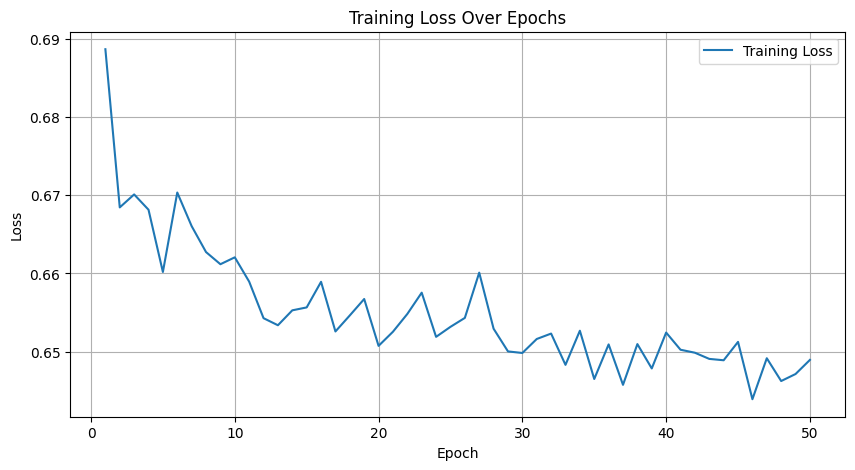

In [ ]:
# Train the model
final_model, train_losses = train_final_model(
    final_model,
    train_loader,
    criterion,
    optimizer,
    num_epochs=best_params['num_epochs'],
    device=device,
)

In [ ]:
import pickle

In [ ]:
# Save model
model_path = '/content/drive/MyDrive/MSc_Final_Project/03_model_development/01_feature_set_1/05_tcn_model_fused_decision/static_and_dynamic_data/best_models/experiment_2/final_model.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(final_model, f)

**Evaluate final model**

In [ ]:
# Load the final model
model_path = '/content/drive/MyDrive/MSc_Final_Project/03_model_development/01_feature_set_1/05_tcn_model_fused_decision/static_and_dynamic_data/best_models/experiment_2/final_model.pkl'
with open(model_path, 'rb') as f:
    final_model = pickle.load(f)

In [ ]:
# Evaluate final model
_, predictions = evaluate_model(final_model, test_loader, device)

Accuracy: 0.6089
Precision: 0.4268
Recall (Sensitivity): 0.5566
F1 Score: 0.4831
ROC AUC: 0.6300
Specificity: 0.6345


Accuracy: 0.6089
Precision: 0.4268
Recall (Sensitivity): 0.5566
F1 Score: 0.4831
ROC AUC: 0.6300
Specificity: 0.6345

In [ ]:
# Save predictions for ensemble
np.save('/content/drive/MyDrive/MSc_Final_Project/03_model_development/01_feature_set_1/05_tcn_model_fused_decision/static_and_dynamic_data/best_models/experiment_2/predictions.npy', predictions)

In [ ]:
# Calculate F1 minority
calculate_f1_minority(final_model, test_loader, device)

0.48314606741573035

**Confusion matrix**

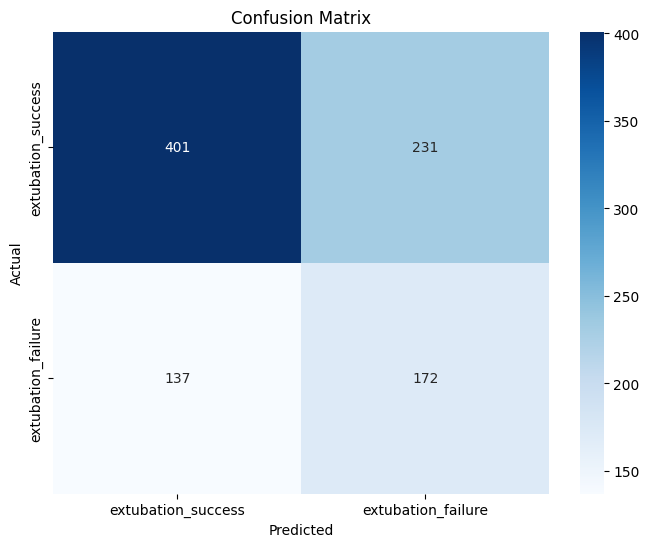

In [ ]:
y_true, y_pred, y_scores = get_model_predictions(final_model, test_loader, device)

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plot_confusion_matrix(cm, class_names)

**Plot ROC curve**

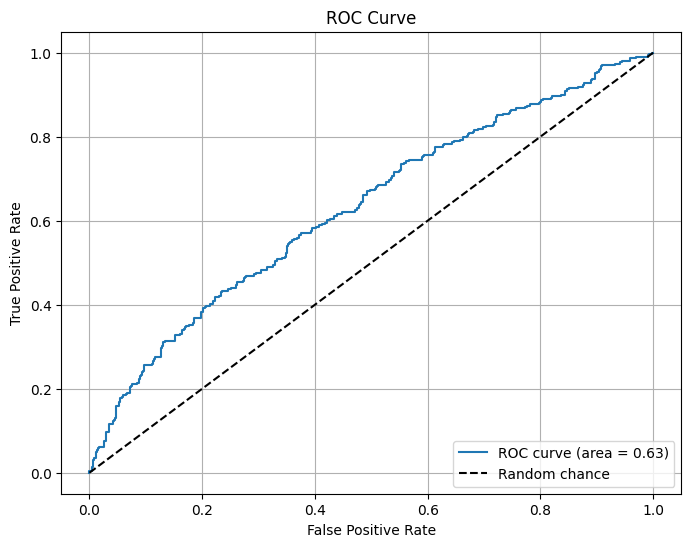

In [ ]:
plot_roc_curve(final_model, test_loader, device)

**Find best threshold**

In [ ]:
find_best_threshold_and_evaluate(final_model, test_loader, device)

Best Threshold: 0.43
Best Metric Value: 0.5105438401775805
Accuracy: 0.5313
Precision: 0.3885
Recall: 0.7443
F1 Score: 0.5105
ROC AUC: 0.6300
Specificity: 0.4272


{'best_threshold': 0.43,
 'best_metric_value': 0.5105438401775805,
 'accuracy': 0.5313496280552603,
 'precision': 0.3885135135135135,
 'recall': 0.7443365695792881,
 'f1_score': 0.5105438401775805,
 'roc_auc': 0.6300131088443733,
 'specificity': 0.4272151898734177}

Predictions from this model are a lot more balanced, likley due to the use of undersampling.

# **Model Interpretability**

**Feature ablation**

In [ ]:
# Load the feature names
low_feature_names = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/dynamic_data/feature_subsets_run_2/low_freq_feature_names_v1.npy'
medium_feature_names = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/dynamic_data/feature_subsets_run_2/medium_freq_feature_names_v1.npy'
high_feature_names = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/dynamic_data/feature_subsets_run_2/high_freq_feature_names_v1.npy'

low_freq_feature_names = np.load(low_feature_names, allow_pickle=True)
medium_freq_feature_names = np.load(medium_feature_names, allow_pickle=True)
high_freq_feature_names = np.load(high_feature_names, allow_pickle=True)

print(low_freq_feature_names)
print(medium_freq_feature_names)
print(high_freq_feature_names)

['PH (Arterial)' 'Arterial CO2 Pressure' 'Arterial O2 pressure']
['Inspired O2 Fraction' 'Tidal Volume (observed)' 'Minute Volume'
 'Peak Insp. Pressure' 'Tidal Volume (spontaneous)']
['O2 saturation pulseoxymetry' 'Respiratory Rate']


In [ ]:
# Load static feature names
train_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/static_data/train_static_v3.parquet'
train_df = pd.read_parquet(train_path)
static_feature_names = train_df.columns.tolist()

# Remove subject_id from the feature list
static_feature_names.remove('subject_id')

# Print the shape of the loaded feature names
print(f"Feature names shape: {len(static_feature_names)}")

Feature names shape: 13


In [ ]:
static_feature_names

['weight',
 'height',
 'BMI',
 'age_group_55-64',
 'age_group_65-74',
 'age_group_≤44',
 'age_group_≥75',
 'gender_M',
 'ethnicity_ASIAN',
 'ethnicity_BLACK',
 'ethnicity_HISPANIC',
 'ethnicity_OTHER',
 'ethnicity_WHITE']

Ablating low frequency feature PH (Arterial) (1/3)
Epoch 0/49, Loss: 1.0105, Val Loss: 0.6345, Val AUC: 0.5944
Epoch 1/49, Loss: 0.8030, Val Loss: 0.6154, Val AUC: 0.6143
Epoch 2/49, Loss: 0.6916, Val Loss: 0.6221, Val AUC: 0.6181
Epoch 3/49, Loss: 0.7086, Val Loss: 0.6502, Val AUC: 0.6202
Epoch 4/49, Loss: 0.6817, Val Loss: 0.6173, Val AUC: 0.6165
Epoch 5/49, Loss: 0.6582, Val Loss: 0.6184, Val AUC: 0.6209
Epoch 6/49, Loss: 0.6447, Val Loss: 0.6130, Val AUC: 0.6296
Epoch 7/49, Loss: 0.6507, Val Loss: 0.6108, Val AUC: 0.6187
Epoch 8/49, Loss: 0.6382, Val Loss: 0.6087, Val AUC: 0.6358
Epoch 9/49, Loss: 0.6443, Val Loss: 0.6120, Val AUC: 0.6281
Epoch 10/49, Loss: 0.6368, Val Loss: 0.6032, Val AUC: 0.6451
Epoch 11/49, Loss: 0.6367, Val Loss: 0.6083, Val AUC: 0.6444
Epoch 12/49, Loss: 0.6379, Val Loss: 0.6121, Val AUC: 0.6321
Epoch 13/49, Loss: 0.6277, Val Loss: 0.6209, Val AUC: 0.6412
Epoch 14/49, Loss: 0.6296, Val Loss: 0.6010, Val AUC: 0.6457
Epoch 15/49, Loss: 0.6261, Val Loss: 0.6053,

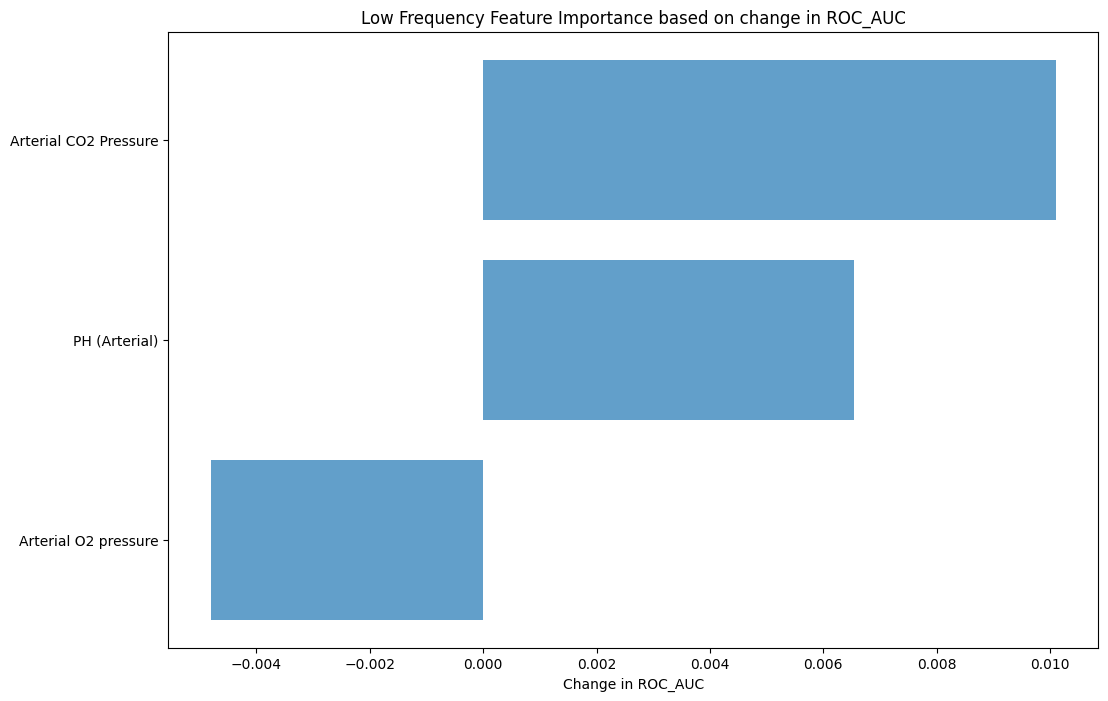

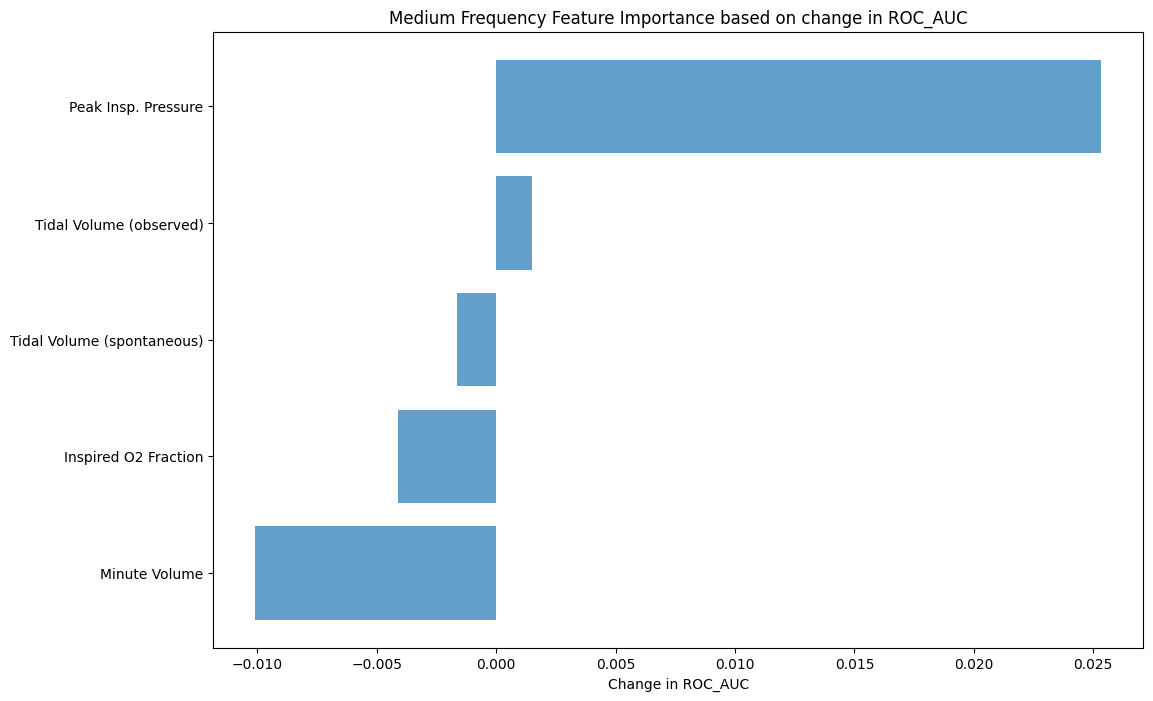

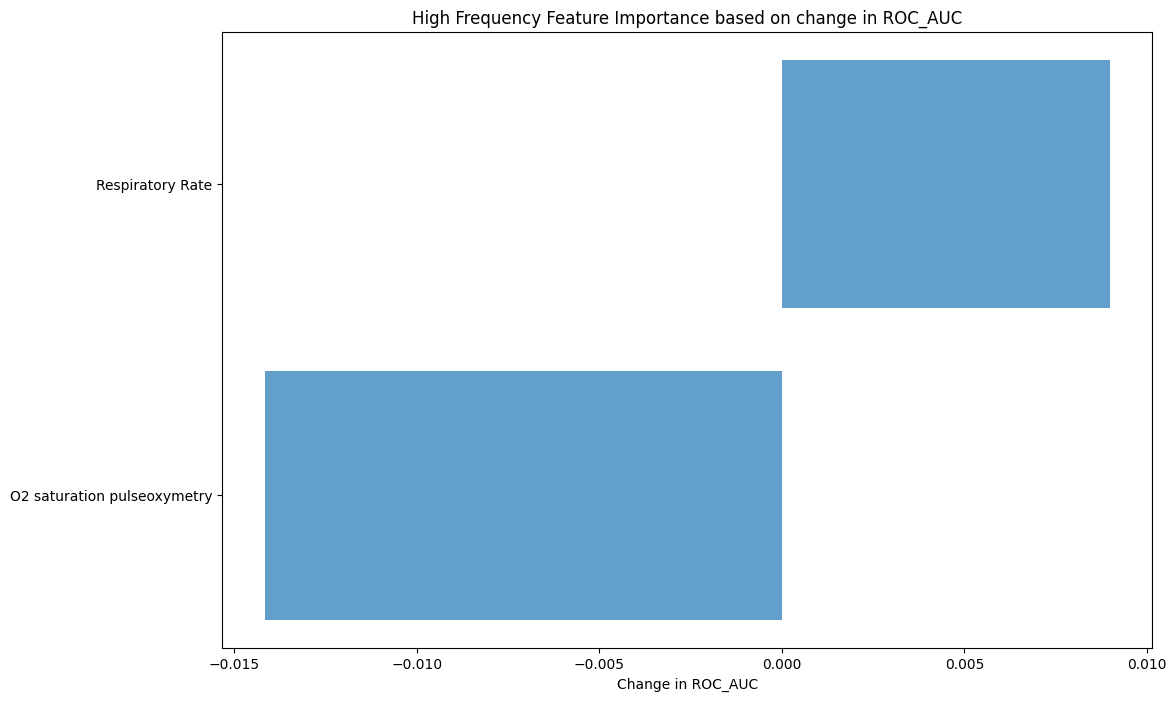

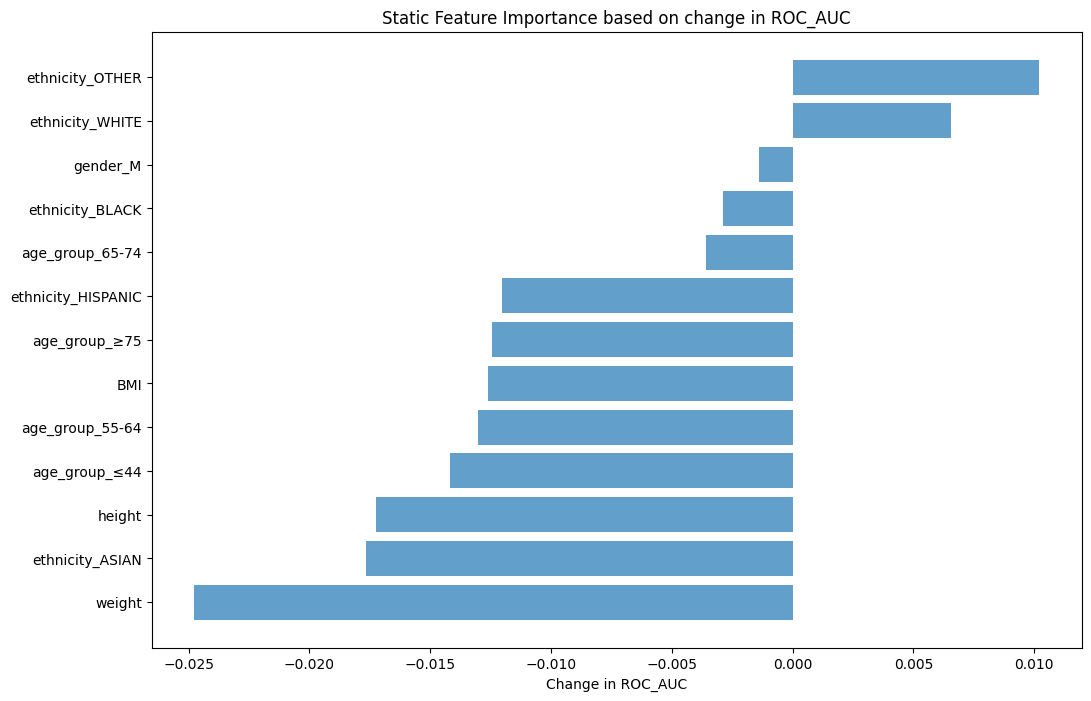

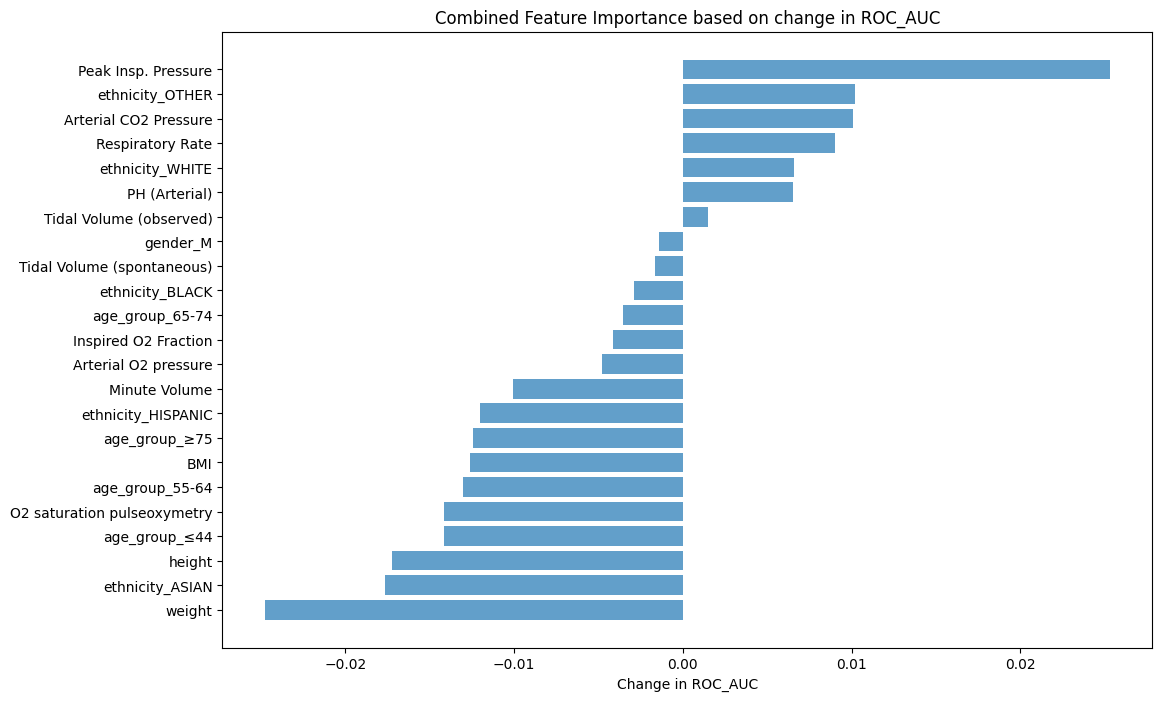

In [ ]:
# Run feature ablation
feature_importances = feature_ablation_with_names(low_freq_train_sequences, medium_freq_train_sequences, high_freq_train_sequences, train_static,
                                                  labels_train, low_freq_test_sequences, medium_freq_test_sequences, high_freq_test_sequences, test_static, labels_test,
                                                  final_model, best_params, device, low_freq_feature_names, medium_freq_feature_names, high_freq_feature_names, static_feature_names)

In [ ]:
feature_importances

,accuracy,precision,recall,f1,roc_auc,specificity
Peak Insp. Pressure,-0.074389,-0.181044,0.456311,0.310924,0.025322,-0.456311
ethnicity_OTHER,-0.070138,-0.279083,0.517799,0.409526,0.010211,-0.517799
Arterial CO2 Pressure,-0.071201,-0.206534,0.495146,0.371052,0.010108,-0.495146
Respiratory Rate,-0.066950,-0.150124,0.508091,0.393594,0.008992,-0.508091
ethnicity_WHITE,-0.076514,-0.297339,0.488673,0.358886,0.006565,-0.488673
PH (Arterial),-0.072264,-0.201772,0.485437,0.355239,0.006539,-0.485437
Tidal Volume (observed),-0.076514,-0.231738,0.469256,0.328860,0.001505,-0.469256
gender_M,-0.066950,-0.132025,0.495146,0.372359,-0.001408,-0.495146
Tidal Volume (spontaneous),-0.066950,-0.184312,0.521036,0.415868,-0.001649,-0.521036
ethnicity_BLACK,-0.075452,-0.169975,0.436893,0.283685,-0.002868,-0.436893


In [ ]:
# Combine all dynamic feature names
all_dynamic_feature_names = np.concatenate((low_freq_feature_names, medium_freq_feature_names, high_freq_feature_names))
all_dynamic_feature_names = all_dynamic_feature_names.tolist()
feature_importances['feature'] = feature_importances.index

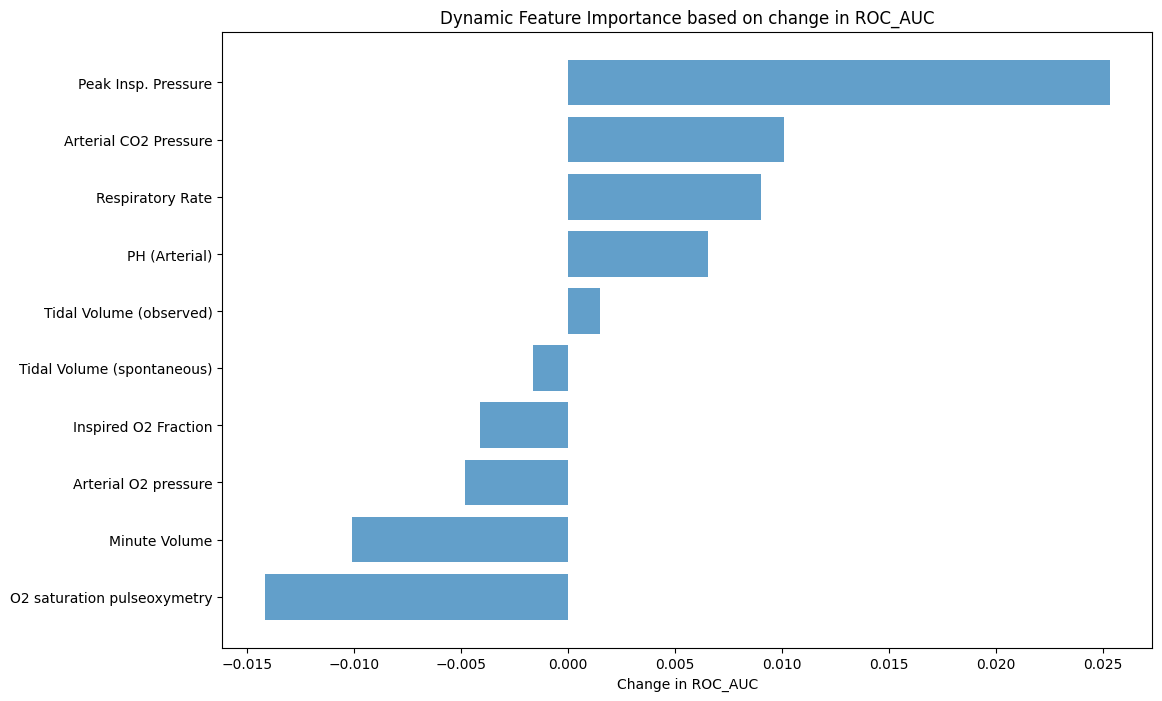

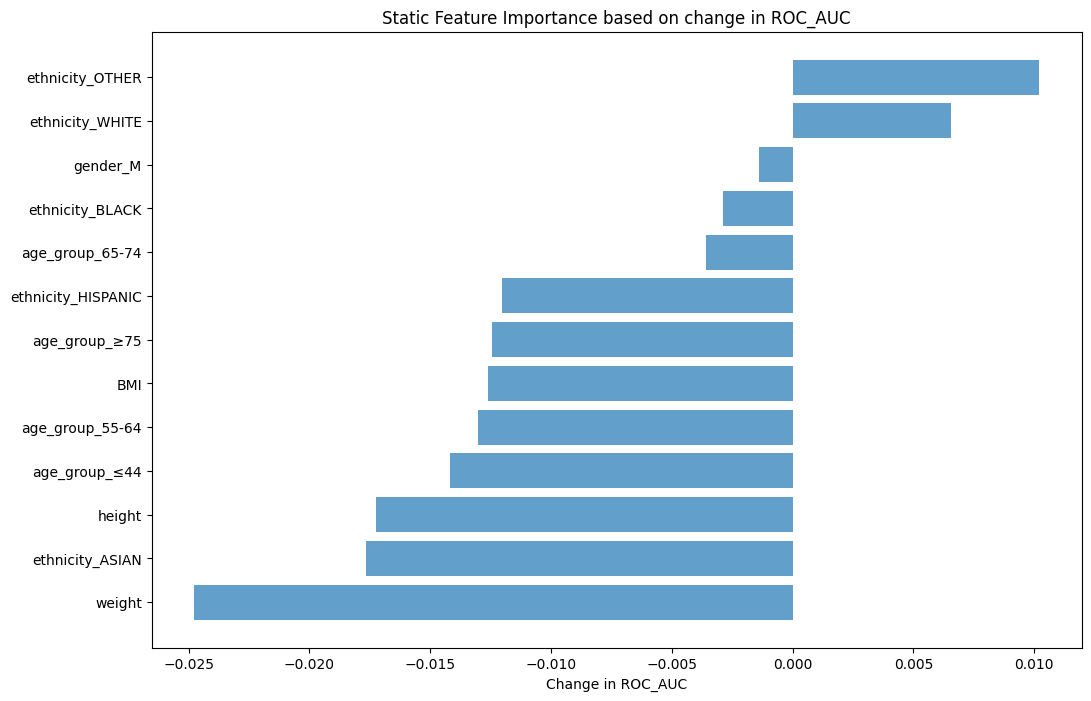

In [ ]:
plot_feature_importances(all_dynamic_feature_names, static_feature_names, feature_importances)